In [1]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
def clean_data(file):
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    df.drop(['High','Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
    
    train5Y = df.loc[datetime.date(2014,1,1): datetime.date(2018,12,31)]
    train10Y = df.loc[datetime.date(2009,1,1): datetime.date(2018,12,31)]
    test1M = df.loc[datetime.date(2019,1,1): datetime.date(2019,1,31)]
    test6M = df.loc[datetime.date(2019,1,1): datetime.date(2019,6,30)]
    
    return train5Y, train10Y, test1M, test6M

KO_train5, KO_train10, KO_test1, KO_test6 = clean_data("KO.csv")
AMD_train5, AMD_train10, AMD_test1, AMD_test6 = clean_data("AMD.csv")

KO_trains = [KO_train10, KO_train5]
KO_tests = [KO_test1, KO_test6]
AMD_trains = [AMD_train10, AMD_train5]
AMD_tests = [AMD_test1, AMD_test6]

In [3]:
def plot_pred(test, pred, period, title):
    fig, ax = plt.subplots(figsize=(20, 8))
    #fig.suptitle(title, fontsize=16)
    plt.title(title)
    if period == 6:
        ax.plot(KO_test6.index, pred, label = "Predicted Prices")
        ax.plot(KO_test6.index, np.array(test), label = "Actual Prices")
    else:
        ax.plot(KO_test1.index, pred, label = "Predicted Prices")
        ax.plot(KO_test1.index, np.array(test), label = "Actual Prices")
    ax.legend()
    if period == 1:
        ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 2, 1)])
    else: 
        ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 7, 1)])
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
        ax.tick_params(axis='x', labelrotation=0)

In [4]:
def split_label(data):
    return data.drop('Close', axis = 1), data['Close']

# Performance Metrics

In [5]:
def mape(y_actual, y_pred):
    y_actual_arr = np.array(y_actual)
    y_pred_arr = np.array(y_pred)
    
    return np.mean(np.abs((y_actual_arr - y_pred_arr)/y_actual_arr))*100

def rmse(y_actual, y_pred):
    y_actual_arr = np.array(y_actual)
    y_pred_arr = np.array(y_pred)
    
    mse = np.square(np.subtract(y_actual_arr,y_pred_arr)).mean()
    return math.sqrt(mse)

def poc(X_test, y_actual, y_pred):
    count = 0
    X_test = np.array(X_test)
    y_actual = np.array(y_actual)
    y_pred = np.array(y_pred)
    
    for i in range(len(X_test)):
        if y_actual[i] > X_test[i] and y_pred[i] > X_test[i]:
            count += 1
        elif y_actual[i] < X_test[i] and y_pred[i] < X_test[i]:
            count += 1
    
    return (count/len(X_test))*100
        

# Execution Loop

In [6]:
def run(trains, tests, model):
    y_tests = []
    y_preds = []
    rmses = []
    mapes = []
    pocs = []
    times = []
    for train in trains:
        for test in tests:
            strt = time.time()
            X_train, y_train = split_label(train)
            X_train = np.array(X_train)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            

            X_test, y_test = split_label(test)
            X_test = np.array(X_test)
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
            
            
            model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 20, epochs = 30)
            y_pred = model.predict(X_test)
            
            y_preds.append(y_pred)
            y_tests.append(y_test)
            
            rmses.append(rmse(y_test, y_pred))
            mapes.append(mape(y_test, y_pred))
            pocs.append(poc(X_test, y_test, y_pred))
            times.append(time.time() - strt)
            
    return y_tests, y_preds, rmses, mapes, pocs, times

def print_perf(y_tests, y_preds, rmses, mapes, pocs, times, stock, plots = True, comp = True):
    print(stock + "\n")
    print("10Y Data - 1Mo Prediction")
    print("RMSE:", rmses[0])
    print("MAPE:", mapes[0])
    print("POC:", pocs[0])
    print("Execution Time:", times[0], "seconds \n")
    if plots:
        plot_pred(y_tests[0], y_preds[0], 1, "10Y Data - 1Mo Prediction")
    
    if comp:
        print("10Y Data - 6Mo Prediction")
        print("RMSE:", rmses[1])
        print("MAPE:", mapes[1])
        print("POC:", pocs[1])
        print("Execution Time:", times[1], "seconds \n")
        if plots:
            plot_pred(y_tests[1], y_preds[1], 6, "10Y Data - 6Mo Prediction")

        print("5Y Data - 1Mo Prediction")
        print("RMSE:", rmses[2])
        print("MAPE:", mapes[2])
        print("POC:", pocs[2])
        print("Execution Time:", times[2], "seconds \n")
        if plots:
            plot_pred(y_tests[2], y_preds[2], 1, "5Y Data - 1Mo Prediction")

        print("5Y Data - 6Mo Prediction")
        print("RMSE:", rmses[3])
        print("MAPE:", mapes[3])
        print("POC:", pocs[3])
        print("Execution Time:", times[3], "seconds \n")
        if plots:
            plot_pred(y_tests[3], y_preds[3], 6, "5Y Data - 6Mo Prediction")

# Recurrent Neural Networks (RNNs)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Activation

In [137]:
def runRNN(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')

    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 1, epochs = epochs)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

In [93]:
epochs = [1, 5, 10, 15, 20, 25, 30, 35, 40]
rs = []
ms = []
ps = []
ts = []

for e in epochs:
    r, m, p, t = runRNN(KO_train10, KO_test6, e)
    rs.append(r)
    ms.append(m)
    ps.append(p)
    ts.append(t)

4/4 [==============================] - 0s 2ms/step
Epoch 1/5
2516/2516 [==============================] - 7s 2ms/step - loss: 0.0089 - val_loss: 4.1485e-04
Epoch 2/5
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 1.5660e-04
Epoch 3/5
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0012 - val_loss: 1.5408e-04
Epoch 4/5
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/5
4/4 [==============================] - 0s 3ms/step
Epoch 1/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 2/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 2.0563e-04
Epoch 3/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 1.6611e-04
Epoch 4/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 5/10
2516/2516 [==============================] - 

Epoch 25/25
4/4 [==============================] - 0s 3ms/step
Epoch 1/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 2/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 4.3215e-04
Epoch 3/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 1.3900e-04
Epoch 4/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 1.9945e-04
Epoch 6/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 2.1104e-04
Epoch 7/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 1.5707e-04
Epoch 9/30
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 0.0026

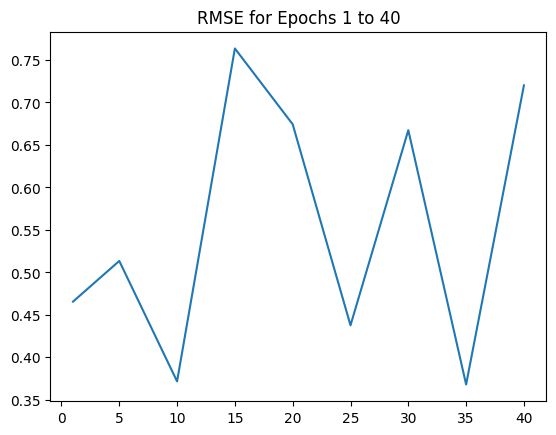

In [94]:
plt.plot(epochs, rs)
plt.title("RMSE for Epochs 1 to 40")
plt.show()

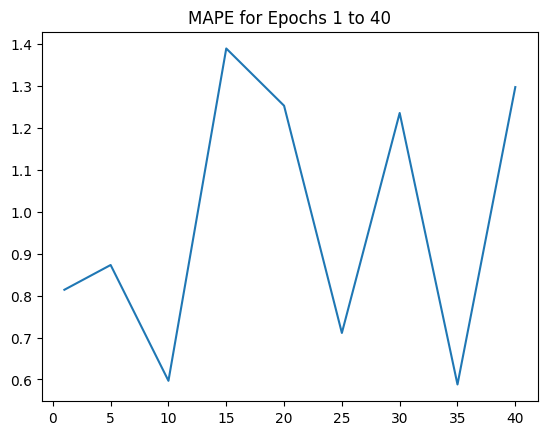

In [95]:
plt.plot(epochs, ms)
plt.title("MAPE for Epochs 1 to 40")
plt.show()

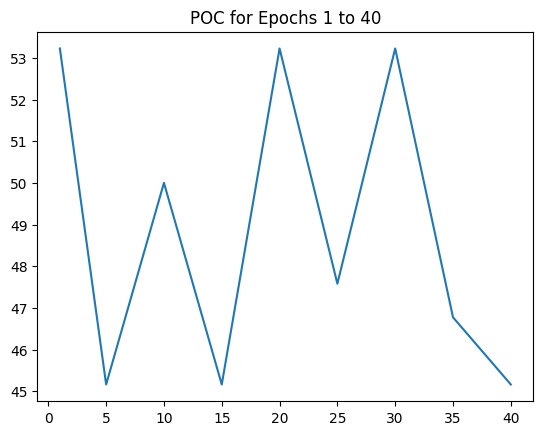

In [98]:
plt.plot(epochs, ps)
plt.title("POC for Epochs 1 to 40")
plt.show()

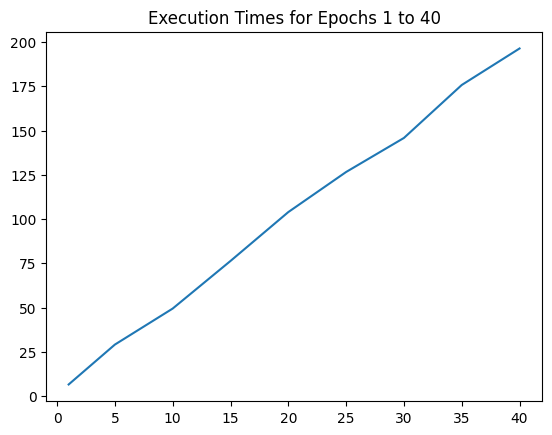

In [97]:
plt.plot(epochs, ts)
plt.title("Execution Times for Epochs 1 to 40")
plt.show()

Epoch 1/35
2516/2516 [==============================] - 7s 2ms/step - loss: 0.0084 - val_loss: 4.5193e-04
Epoch 2/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 4.5758e-04
Epoch 4/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 1.4422e-04
Epoch 5/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 7.5528e-04
Epoch 6/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 8.9337e-04
Epoch 7/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 1.3469e-04
Epoch 8/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 1.6604e-04
Epoch 9/35
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 6.9857e-04
Epoch 10/35
2516/2516 [===========================

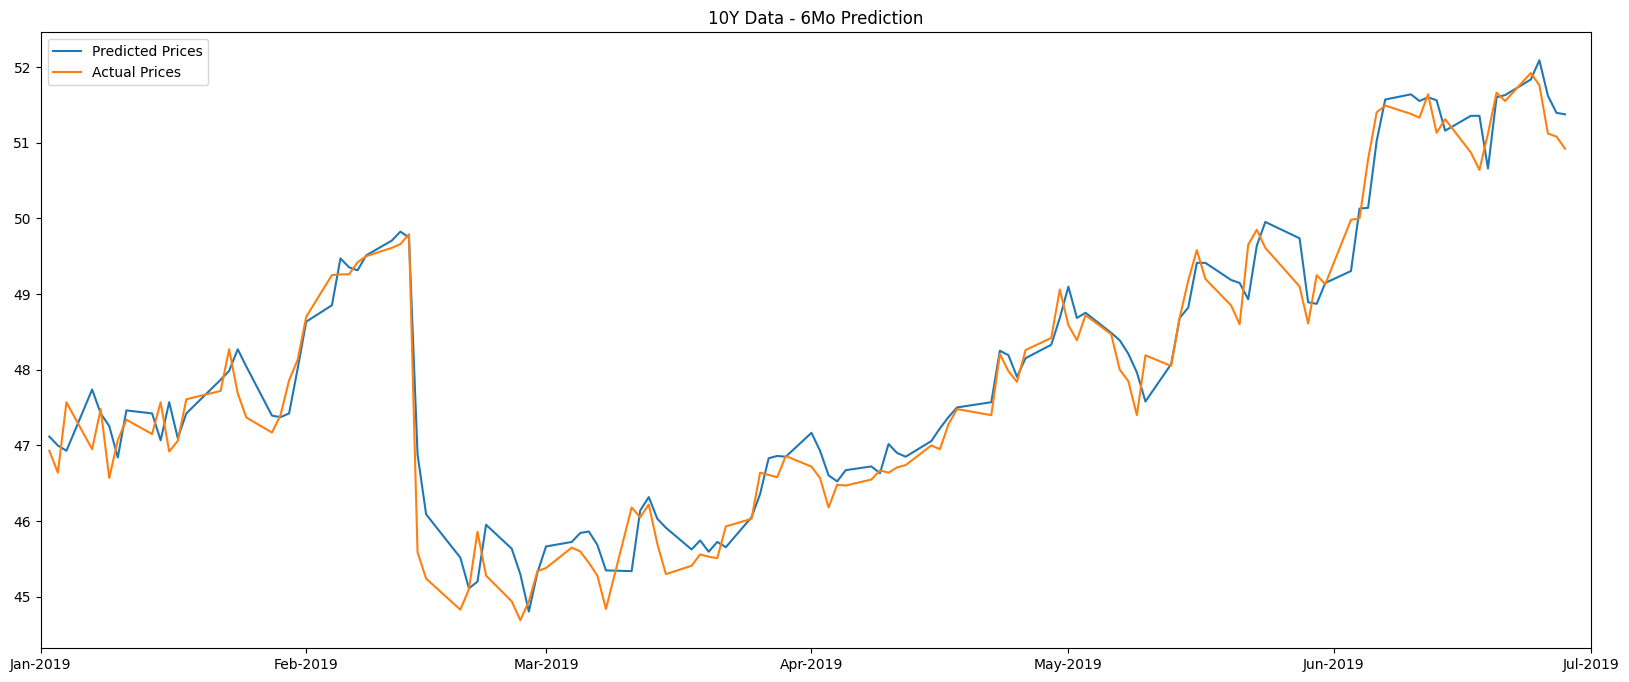

In [104]:
y_pred, y_test, r, m, p, t = runRNN(KO_train10, KO_test6, 35)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0068 - val_loss: 1.7695e-04
Epoch 2/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 6.1404e-04
Epoch 4/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 9.0717e-04
Epoch 6/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 6.8579e-04
Epoch 9/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 2.6160e-04
Epoch 10/10
1/1 [==============================] - 0s 170ms/st

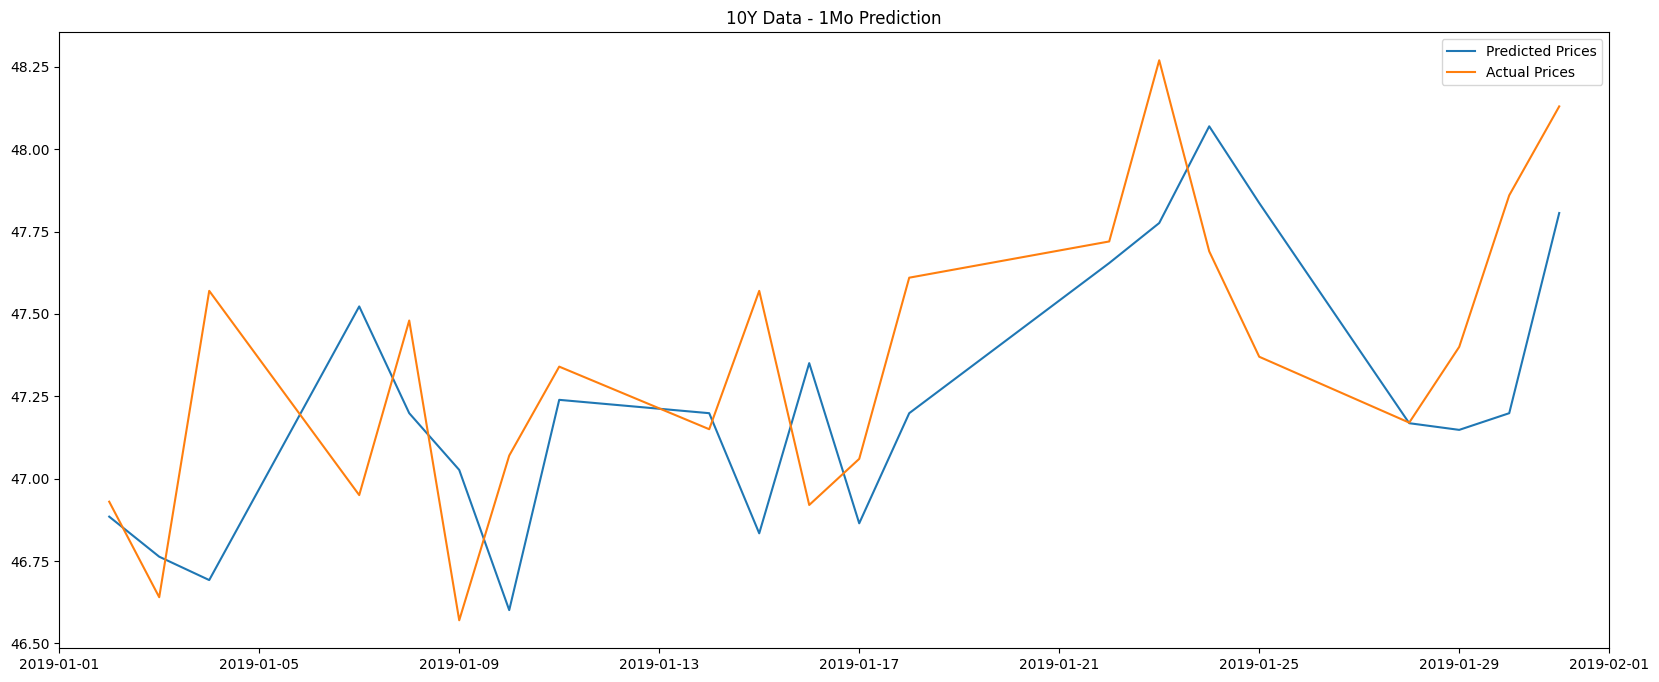

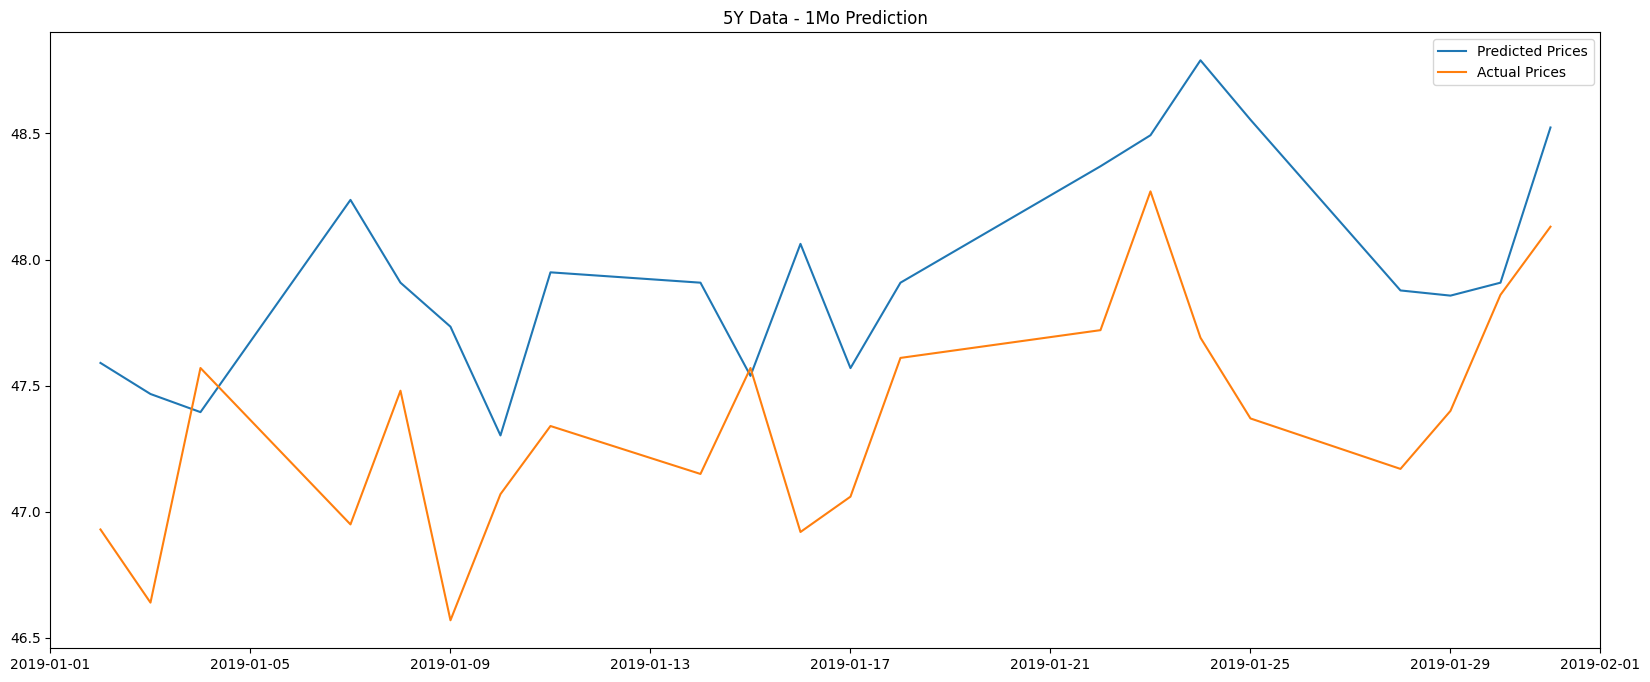

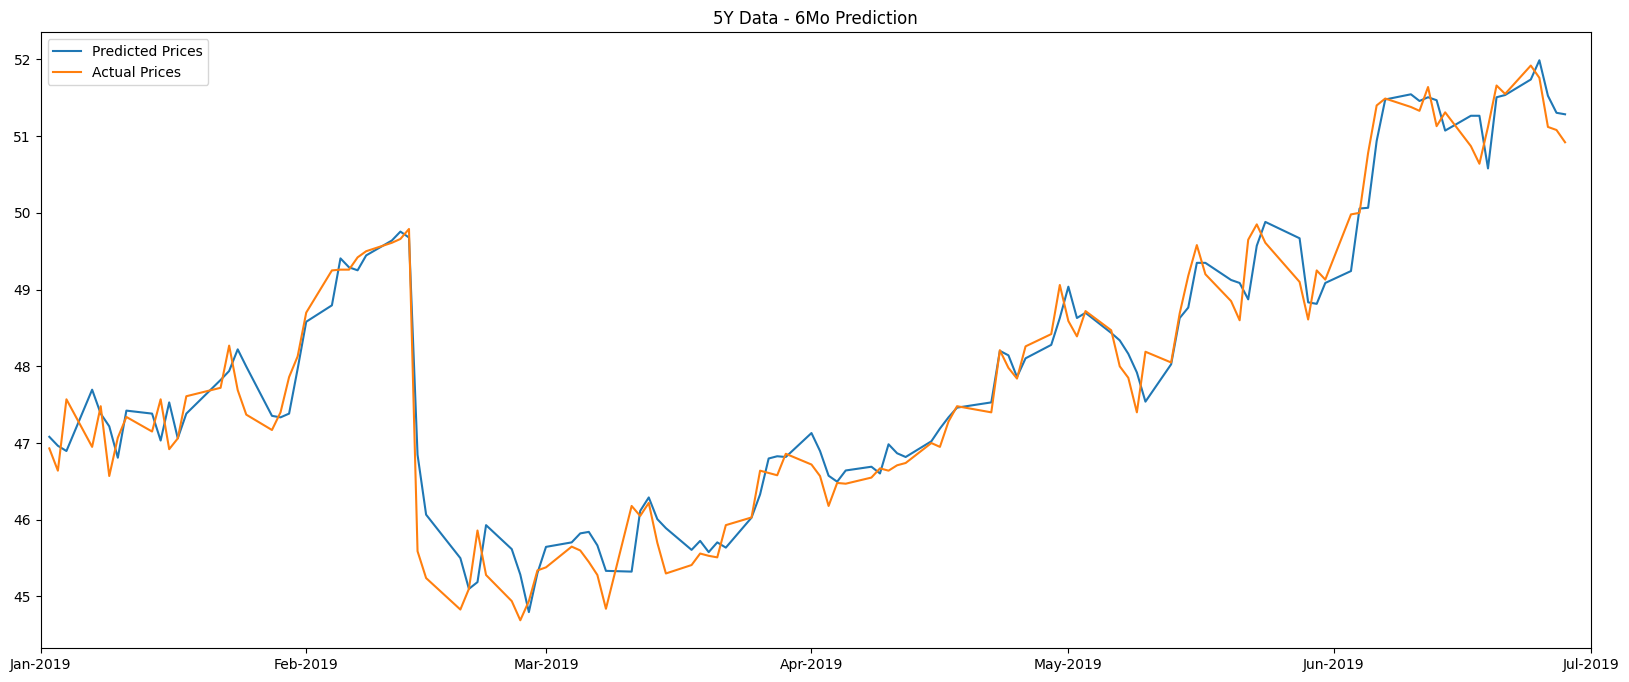

In [110]:
y_pred, y_test, r, m, p, t = runRNN(KO_train10, KO_test1, 10)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runRNN(KO_train5, KO_test1, 10)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runRNN(KO_train5, KO_test6, 10)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

# Stacked RNNs

In [138]:
def runRNN_stacked_2(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.5))
    #model.add(SimpleRNN(75, input_shape = (1,1), return_sequences = True))
    #model.add(Dropout(0.4))
    model.add(SimpleRNN(25, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 1, epochs = epochs)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

def runRNN_stacked_3(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(SimpleRNN(75, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(50, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(25, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 1, epochs = epochs)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

def runRNN_stacked_4(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(SimpleRNN(100, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(75, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(50, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(25, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 1, epochs = epochs)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

In [153]:
stacks = [1, 2, 3, 4]
rs = []
ms = []
ps = []
ts = []


y_pred, y_test, r, m, p, t = runRNN(KO_train10, KO_test6, 3)
rs.append(r)
ms.append(m)
ps.append(p)
ts.append(t)

y_pred, y_test, r, m, p, t = runRNN_stacked_2(KO_train10, KO_test6, 3)
rs.append(r)
ms.append(m)
ps.append(p)
ts.append(t)

y_pred, y_test, r, m, p, t = runRNN_stacked_3(KO_train10, KO_test6, 3)
rs.append(r)
ms.append(m)
ps.append(p)
ts.append(t)

y_pred, y_test, r, m, p, t = runRNN_stacked_4(KO_train10, KO_test6, 3)
rs.append(r)
ms.append(m)
ps.append(p)
ts.append(t)

Epoch 1/3
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0086 - val_loss: 8.8037e-04
Epoch 2/3
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/3
4/4 [==============================] - 0s 7ms/step
Epoch 1/3
2516/2516 [==============================] - 7s 2ms/step - loss: 0.0154 - val_loss: 5.0119e-04
Epoch 2/3
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0044 - val_loss: 4.8891e-04
Epoch 3/3
4/4 [==============================] - 0s 3ms/step
Epoch 1/3
2516/2516 [==============================] - 9s 3ms/step - loss: 0.0181 - val_loss: 0.0045
Epoch 2/3
2516/2516 [==============================] - 7s 3ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 3/3
4/4 [==============================] - 0s 5ms/step
Epoch 1/3
2516/2516 [==============================] - 13s 3ms/step - loss: 0.0266 - val_loss: 0.0093
Epoch 2/3
2516/2516 [==============================] - 9s 4ms/step - loss: 0.0091 - val_loss: 0.0

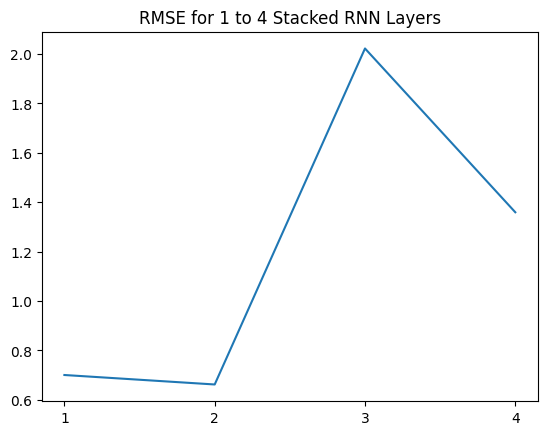

In [156]:
plt.plot(stacks, rs)
plt.title("RMSE for 1 to 4 Stacked RNN Layers")
plt.xticks([1,2,3,4])
plt.show()

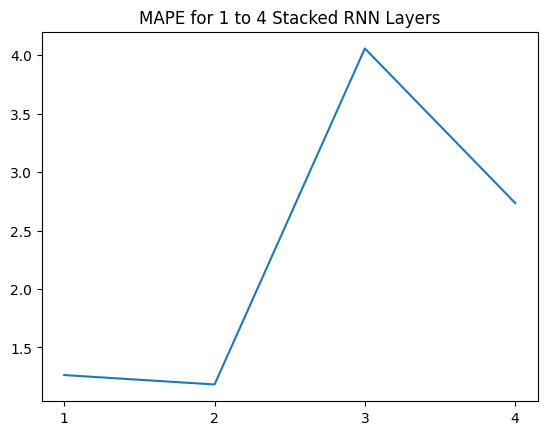

In [157]:
plt.plot(stacks, ms)
plt.title("MAPE for 1 to 4 Stacked RNN Layers")
plt.xticks([1,2,3,4])
plt.show()

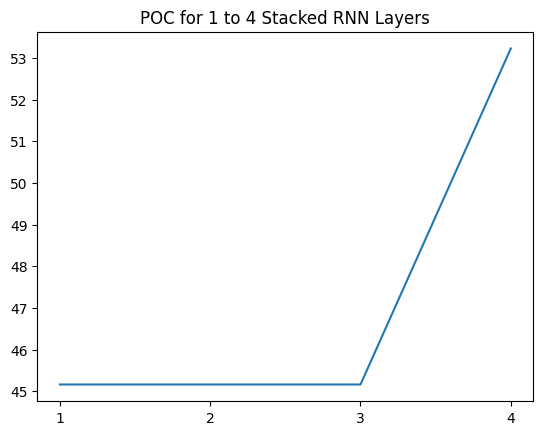

In [158]:
plt.plot(stacks, ps)
plt.title("POC for 1 to 4 Stacked RNN Layers")
plt.xticks([1,2,3,4])
plt.show()

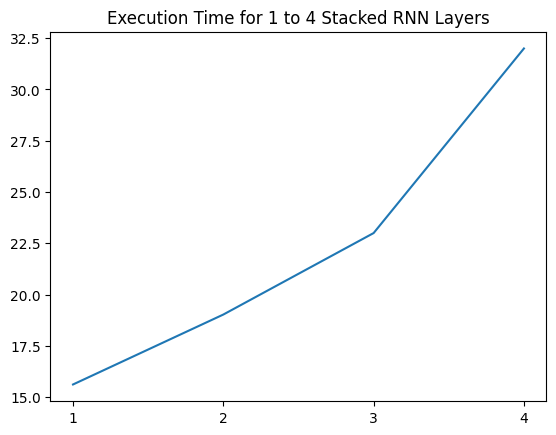

In [159]:
plt.plot(stacks, ts)
plt.title("Execution Time for 1 to 4 Stacked RNN Layers")
plt.xticks([1,2,3,4])
plt.show()

In [167]:
y_pred, y_test, r, m, p, t = runRNN_stacked_2(KO_train10, KO_test6, 10)

Epoch 1/10
2516/2516 [==============================] - 7s 2ms/step - loss: 0.0153 - val_loss: 0.0028
Epoch 2/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0042 - val_loss: 9.9428e-04
Epoch 3/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 4/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 5/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0039 - val_loss: 7.6604e-04
Epoch 6/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0038 - val_loss: 3.8795e-04
Epoch 7/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 8/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 9/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0041 - val_loss: 4.9355e-04
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


10Y Data - 6Mo Prediction
RMSE: 0.3816516124697949
MAPE: 0.6080627760725843
POC: 42.74193548387097
Execution Time: 59.660043239593506 seconds 



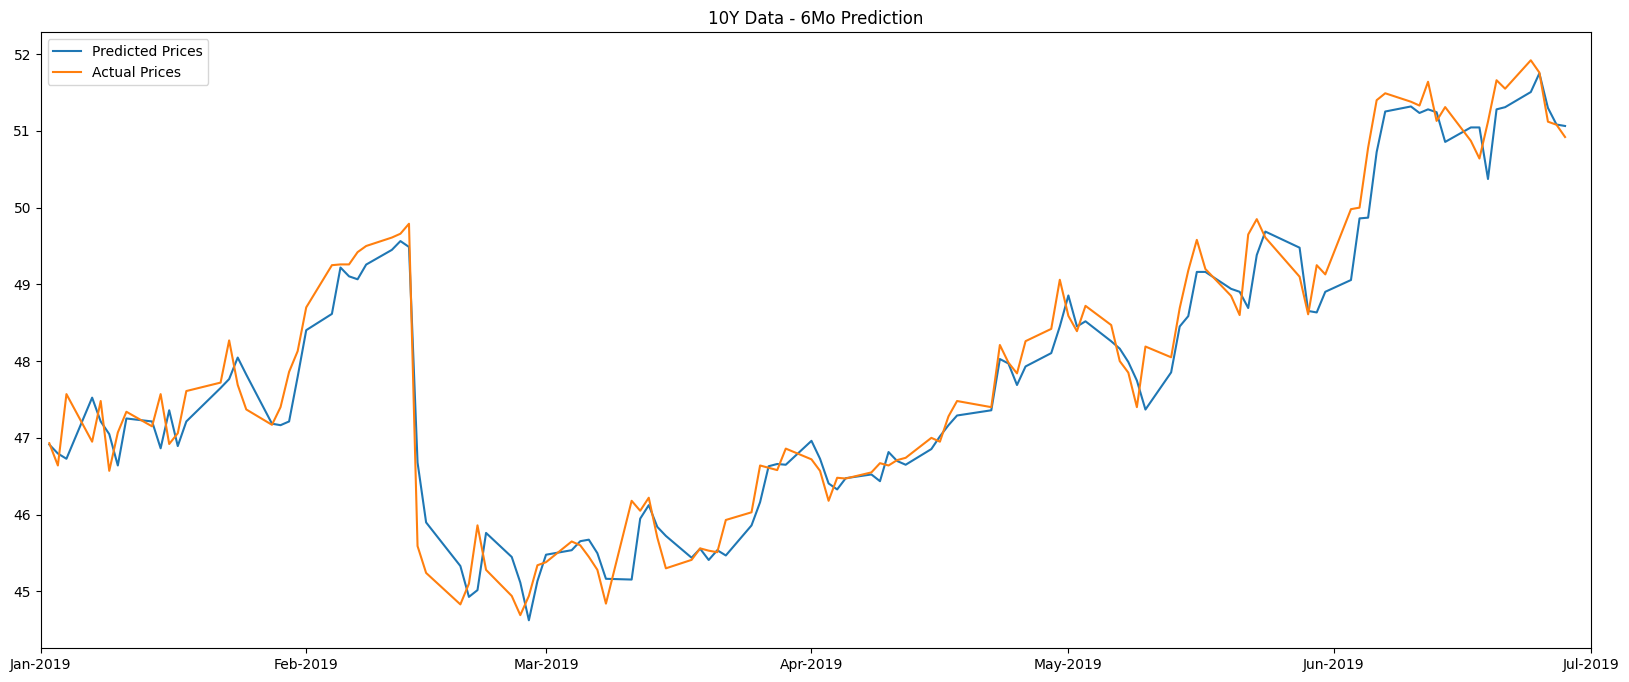

In [168]:
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/10
2516/2516 [==============================] - 8s 3ms/step - loss: 0.0163 - val_loss: 0.0051
Epoch 2/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0040 - val_loss: 8.8814e-04
Epoch 3/10
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0043 - val_loss: 7.4090e-04
Epoch 4/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0040 - val_loss: 1.7927e-04
Epoch 6/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 7/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 8/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0037 - val_loss: 3.7940e-04
Epoch 9/10
2516/2516 [==============================] - 5s 2ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 10/10
1/1 [==============================] - 0s 261ms/step
1

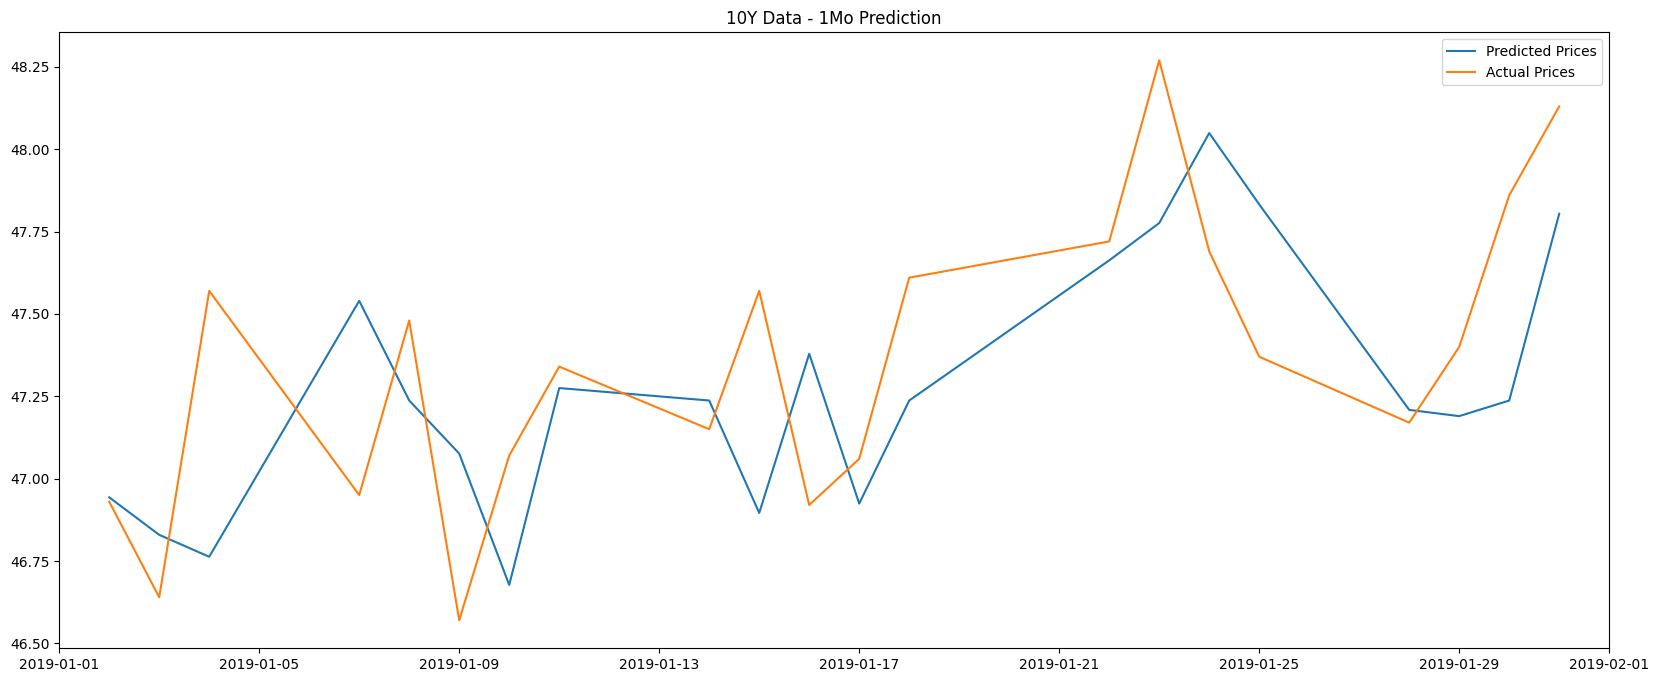

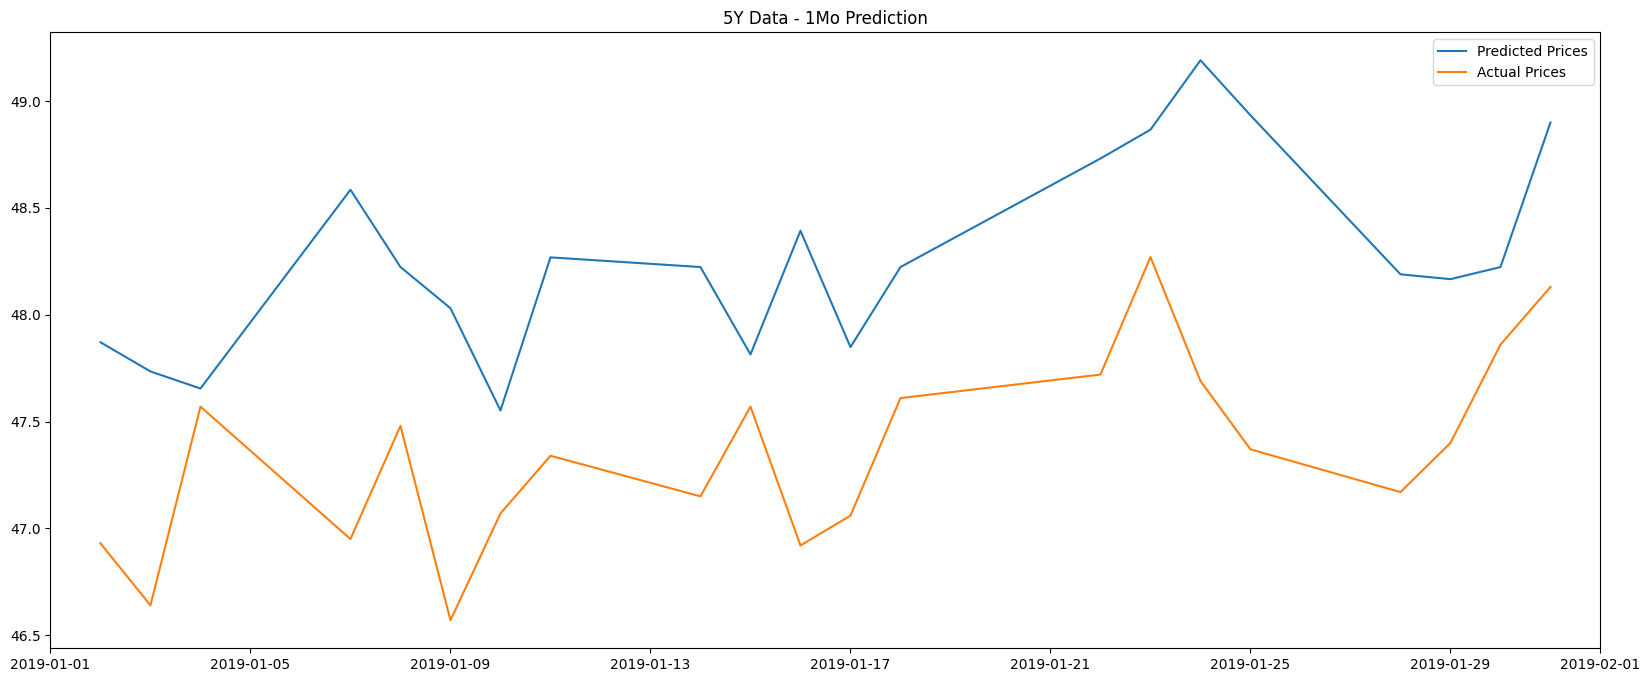

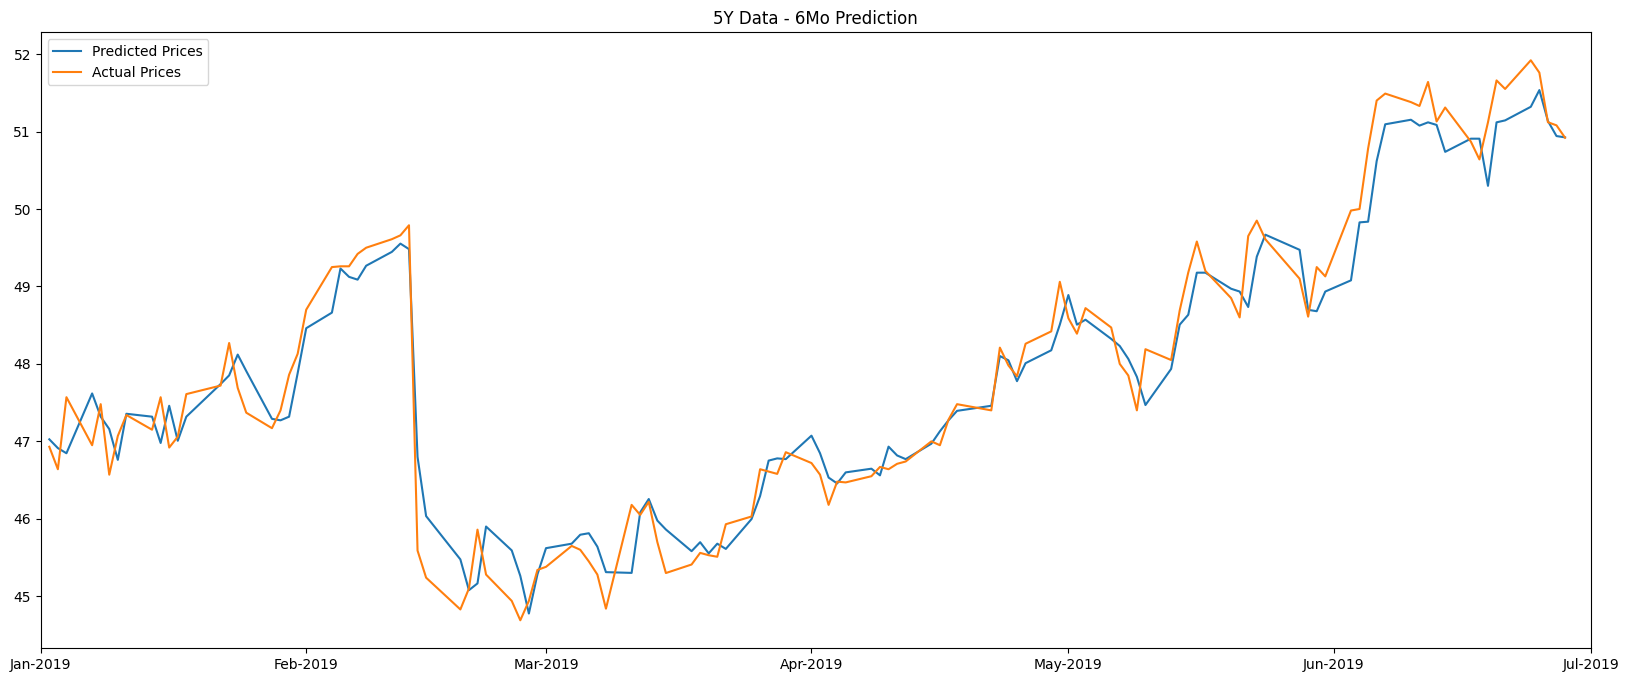

In [177]:
y_pred, y_test, r, m, p, t = runRNN_stacked_2(KO_train10, KO_test1, 10)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runRNN_stacked_2(KO_train5, KO_test1, 10)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runRNN_stacked_2(KO_train5, KO_test6, 10)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

# Gated Recurrent Units (GRUs)

In [11]:
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, Dropout, Activation
from keras.callbacks import ModelCheckpoint

In [12]:
def runGRU1(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(GRU(50, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    
    filepath = "Best-GRU.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only = True, mode = "min")
    cb_list = [checkpoint]
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 10, epochs = epochs, callbacks = cb_list)
    
    new_model = load_model("Best-GRU.hdf5")
    y_pred = new_model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

Epoch 1/100
252/252 [==============================] - 9s 11ms/step - loss: 0.0204 - val_loss: 0.0032
Epoch 2/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0038 - val_loss: 1.9840e-04
Epoch 3/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 5.4169e-04
Epoch 4/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 8.0084e-04
Epoch 5/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 1.3567e-04
Epoch 6/100
252/252 [==============================] - 2s 6ms/step - loss: 9.6745e-04 - val_loss: 5.3597e-04
Epoch 7/100
252/252 [==============================] - 2s 6ms/step - loss: 8.2923e-04 - val_loss: 1.4489e-04
Epoch 8/100
252/252 [==============================] - 1s 5ms/step - loss: 8.2223e-04 - val_loss: 3.2395e-04
Epoch 9/100
252/252 [==============================] - 2s 6ms/step - loss: 7.8017e-04 - val_loss: 1.8150e-04
Epoch 10/100
252/252 [====================

Epoch 76/100
252/252 [==============================] - 2s 6ms/step - loss: 8.7302e-04 - val_loss: 1.8475e-04
Epoch 77/100
252/252 [==============================] - 2s 6ms/step - loss: 8.6460e-04 - val_loss: 1.4088e-04
Epoch 78/100
252/252 [==============================] - 2s 6ms/step - loss: 8.5196e-04 - val_loss: 2.4257e-04
Epoch 79/100
252/252 [==============================] - 2s 6ms/step - loss: 8.3181e-04 - val_loss: 1.3577e-04
Epoch 80/100
252/252 [==============================] - 2s 6ms/step - loss: 8.6309e-04 - val_loss: 5.7884e-04
Epoch 81/100
252/252 [==============================] - 1s 6ms/step - loss: 8.4659e-04 - val_loss: 1.4179e-04
Epoch 82/100
252/252 [==============================] - 2s 6ms/step - loss: 8.5857e-04 - val_loss: 2.2528e-04
Epoch 83/100
252/252 [==============================] - 2s 6ms/step - loss: 8.1288e-04 - val_loss: 8.3383e-04
Epoch 84/100
252/252 [==============================] - 2s 6ms/step - loss: 8.8597e-04 - val_loss: 1.3363e-04
Epoch 85/1

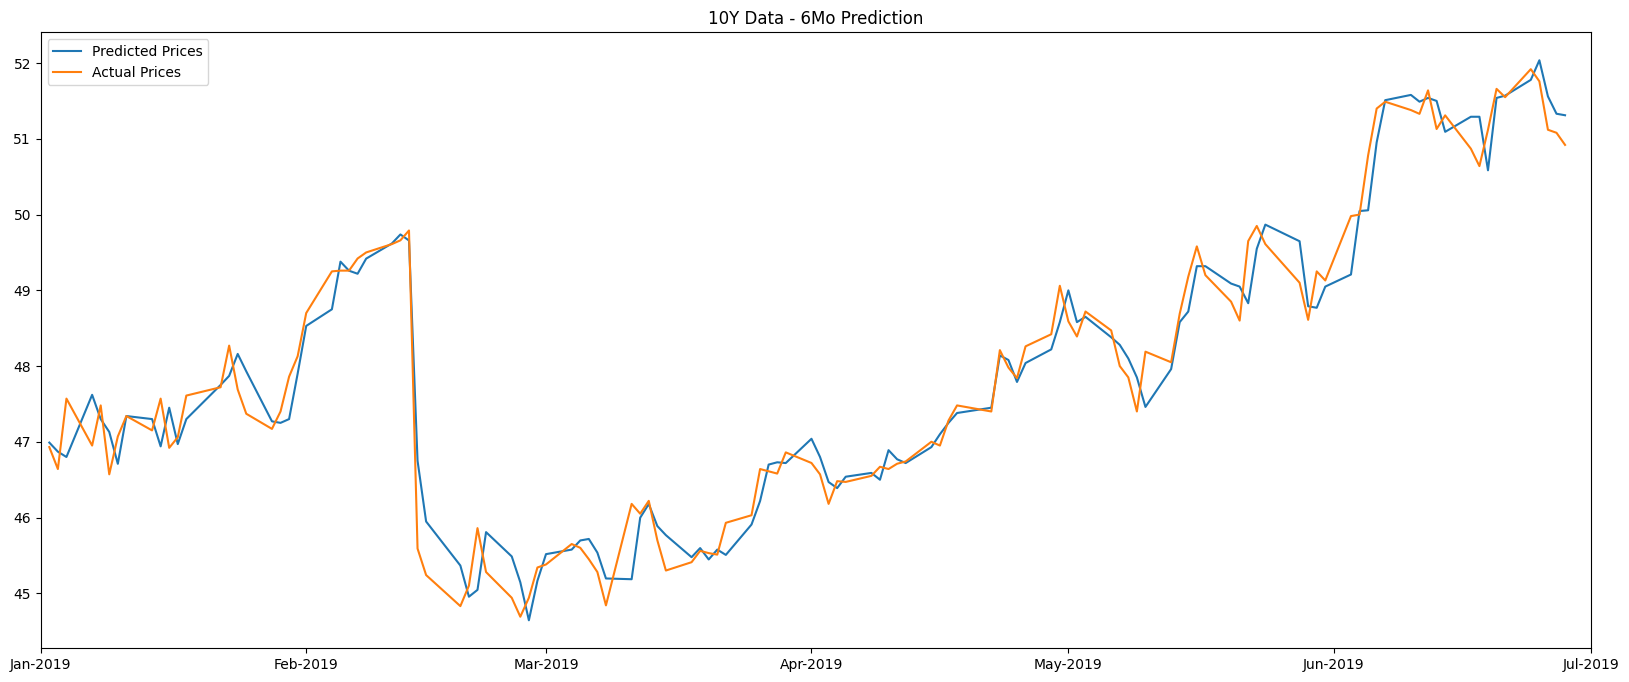

In [18]:
y_pred, y_test, r, m, p, t = runGRU1(KO_train10, KO_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/100
252/252 [==============================] - 9s 11ms/step - loss: 0.0284 - val_loss: 0.0024
Epoch 2/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0040 - val_loss: 1.8370e-04
Epoch 3/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0026 - val_loss: 3.6567e-04
Epoch 4/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 4.5528e-04
Epoch 5/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 2.4152e-04
Epoch 6/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0010 - val_loss: 3.6925e-04
Epoch 7/100
252/252 [==============================] - 2s 6ms/step - loss: 9.9748e-04 - val_loss: 3.2867e-04
Epoch 8/100
252/252 [==============================] - 2s 6ms/step - loss: 9.0180e-04 - val_loss: 2.0241e-04
Epoch 9/100
252/252 [==============================] - 2s 6ms/step - loss: 8.9324e-04 - val_loss: 2.8914e-04
Epoch 10/100
252/252 [========================

Epoch 76/100
252/252 [==============================] - 2s 6ms/step - loss: 8.3652e-04 - val_loss: 5.6877e-04
Epoch 77/100
252/252 [==============================] - 2s 6ms/step - loss: 8.3956e-04 - val_loss: 1.8943e-04
Epoch 78/100
252/252 [==============================] - 2s 6ms/step - loss: 8.9239e-04 - val_loss: 3.1703e-04
Epoch 79/100
252/252 [==============================] - 2s 6ms/step - loss: 8.9471e-04 - val_loss: 4.1465e-04
Epoch 80/100
252/252 [==============================] - 2s 6ms/step - loss: 9.2267e-04 - val_loss: 1.6936e-04
Epoch 81/100
252/252 [==============================] - 1s 6ms/step - loss: 8.4477e-04 - val_loss: 7.3776e-04
Epoch 82/100
252/252 [==============================] - 2s 6ms/step - loss: 8.6201e-04 - val_loss: 3.5485e-04
Epoch 83/100
252/252 [==============================] - 2s 6ms/step - loss: 8.7956e-04 - val_loss: 1.8158e-04
Epoch 84/100
252/252 [==============================] - 2s 6ms/step - loss: 8.5520e-04 - val_loss: 6.0784e-04
Epoch 85/1

Epoch 28/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 29/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 30/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 7.5879e-04
Epoch 31/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.1261e-04
Epoch 32/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 7.4450e-04
Epoch 33/100
126/126 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 34/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 35/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 36/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 7.4632e-04
Epoch 37/100
126/126 [==============================] - 1s 6ms/ste

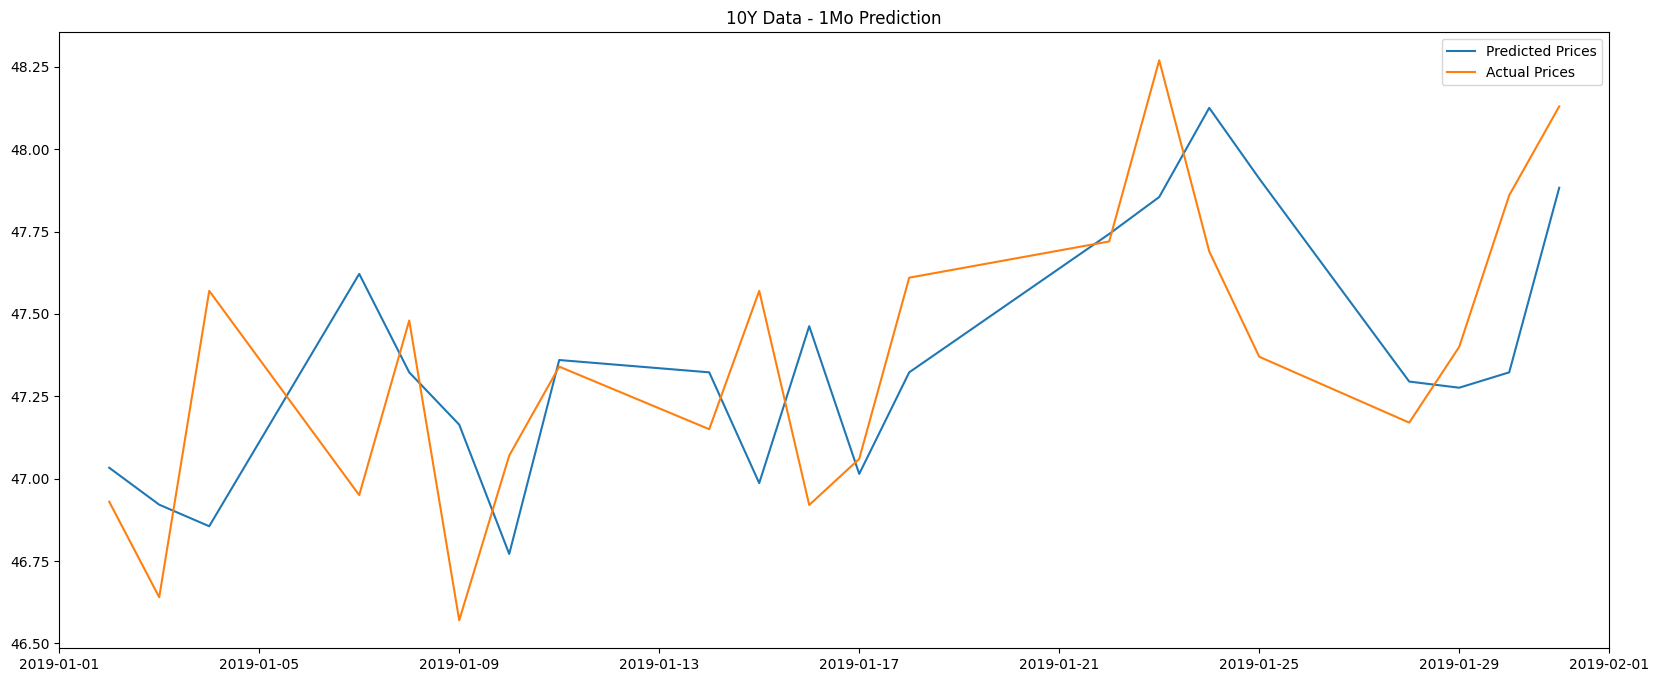

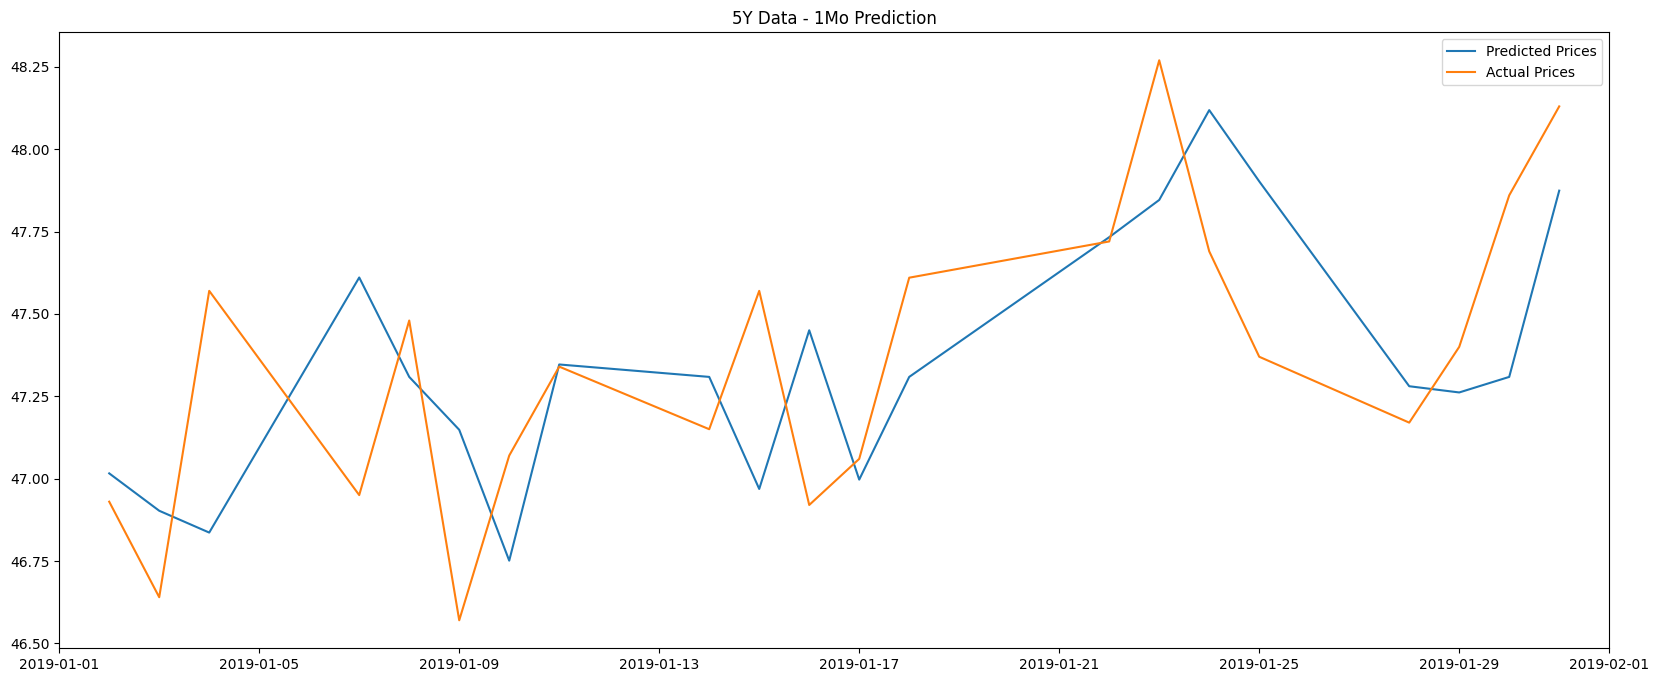

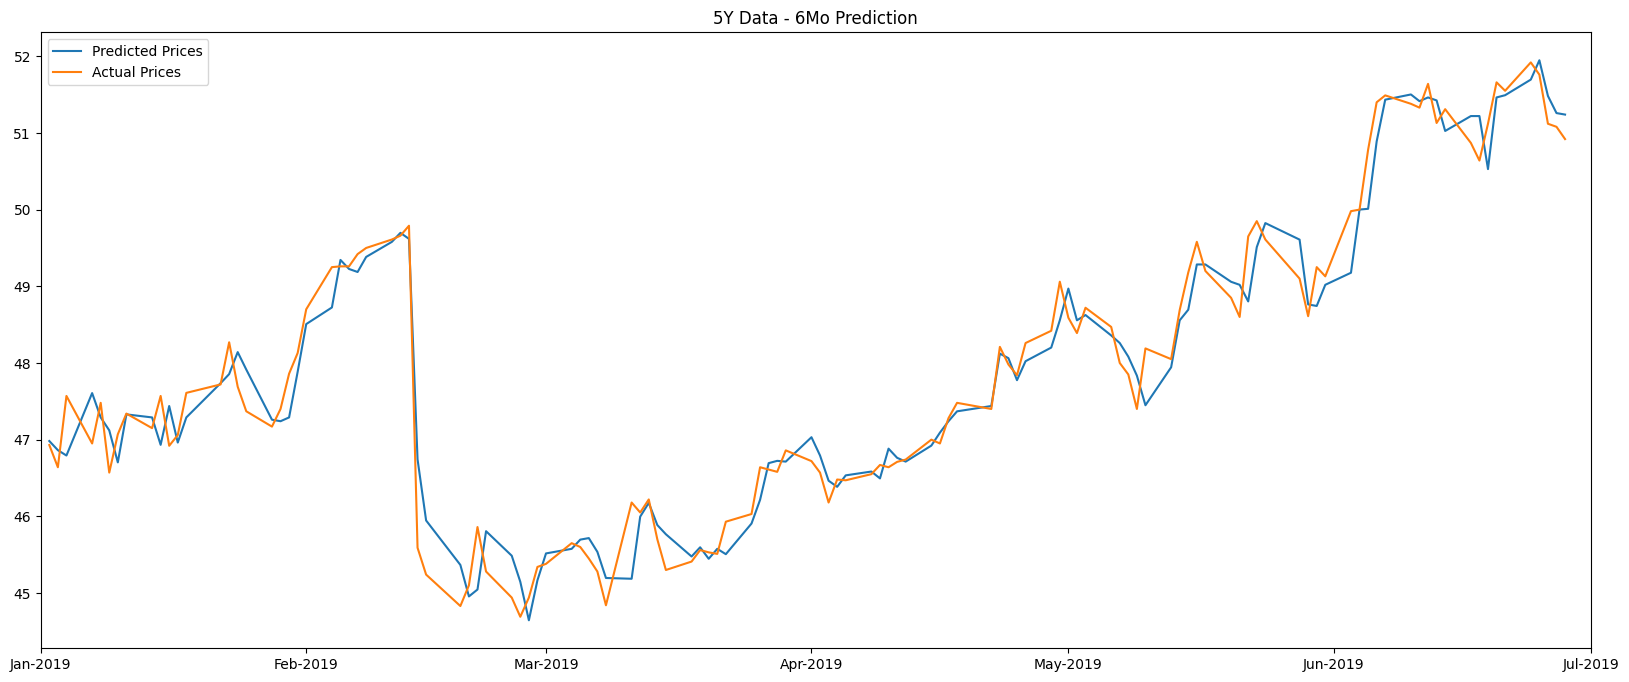

In [19]:
y_pred, y_test, r, m, p, t = runGRU1(KO_train10, KO_test1, 100)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runGRU1(KO_train5, KO_test1, 100)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runGRU1(KO_train5, KO_test6, 100)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

### AMD Stock

Epoch 1/100
252/252 [==============================] - 4s 5ms/step - loss: 0.0048 - val_loss: 6.5703e-04
Epoch 2/100
252/252 [==============================] - 1s 4ms/step - loss: 7.6365e-04 - val_loss: 0.0012
Epoch 3/100
252/252 [==============================] - 1s 4ms/step - loss: 7.0326e-04 - val_loss: 5.8463e-04
Epoch 4/100
252/252 [==============================] - 1s 4ms/step - loss: 6.2585e-04 - val_loss: 0.0019
Epoch 5/100
252/252 [==============================] - 1s 4ms/step - loss: 5.1866e-04 - val_loss: 9.8476e-04
Epoch 6/100
252/252 [==============================] - 1s 4ms/step - loss: 5.1692e-04 - val_loss: 8.9002e-04
Epoch 7/100
252/252 [==============================] - 1s 4ms/step - loss: 5.0808e-04 - val_loss: 0.0022
Epoch 8/100
252/252 [==============================] - 1s 4ms/step - loss: 6.1601e-04 - val_loss: 0.0011
Epoch 9/100
252/252 [==============================] - 1s 4ms/step - loss: 6.0686e-04 - val_loss: 5.9484e-04
Epoch 10/100
252/252 [=================

Epoch 77/100
252/252 [==============================] - 1s 4ms/step - loss: 4.9063e-04 - val_loss: 6.2715e-04
Epoch 78/100
252/252 [==============================] - 1s 4ms/step - loss: 5.7697e-04 - val_loss: 6.9348e-04
Epoch 79/100
252/252 [==============================] - 1s 4ms/step - loss: 5.2689e-04 - val_loss: 8.9170e-04
Epoch 80/100
252/252 [==============================] - 1s 4ms/step - loss: 5.2764e-04 - val_loss: 0.0020
Epoch 81/100
252/252 [==============================] - 1s 4ms/step - loss: 4.8928e-04 - val_loss: 0.0014
Epoch 82/100
252/252 [==============================] - 1s 4ms/step - loss: 4.9442e-04 - val_loss: 8.5044e-04
Epoch 83/100
252/252 [==============================] - 1s 4ms/step - loss: 4.7229e-04 - val_loss: 0.0014
Epoch 84/100
252/252 [==============================] - 1s 4ms/step - loss: 4.9261e-04 - val_loss: 0.0020
Epoch 85/100
252/252 [==============================] - 1s 3ms/step - loss: 5.1343e-04 - val_loss: 6.0354e-04
Epoch 86/100
252/252 [====

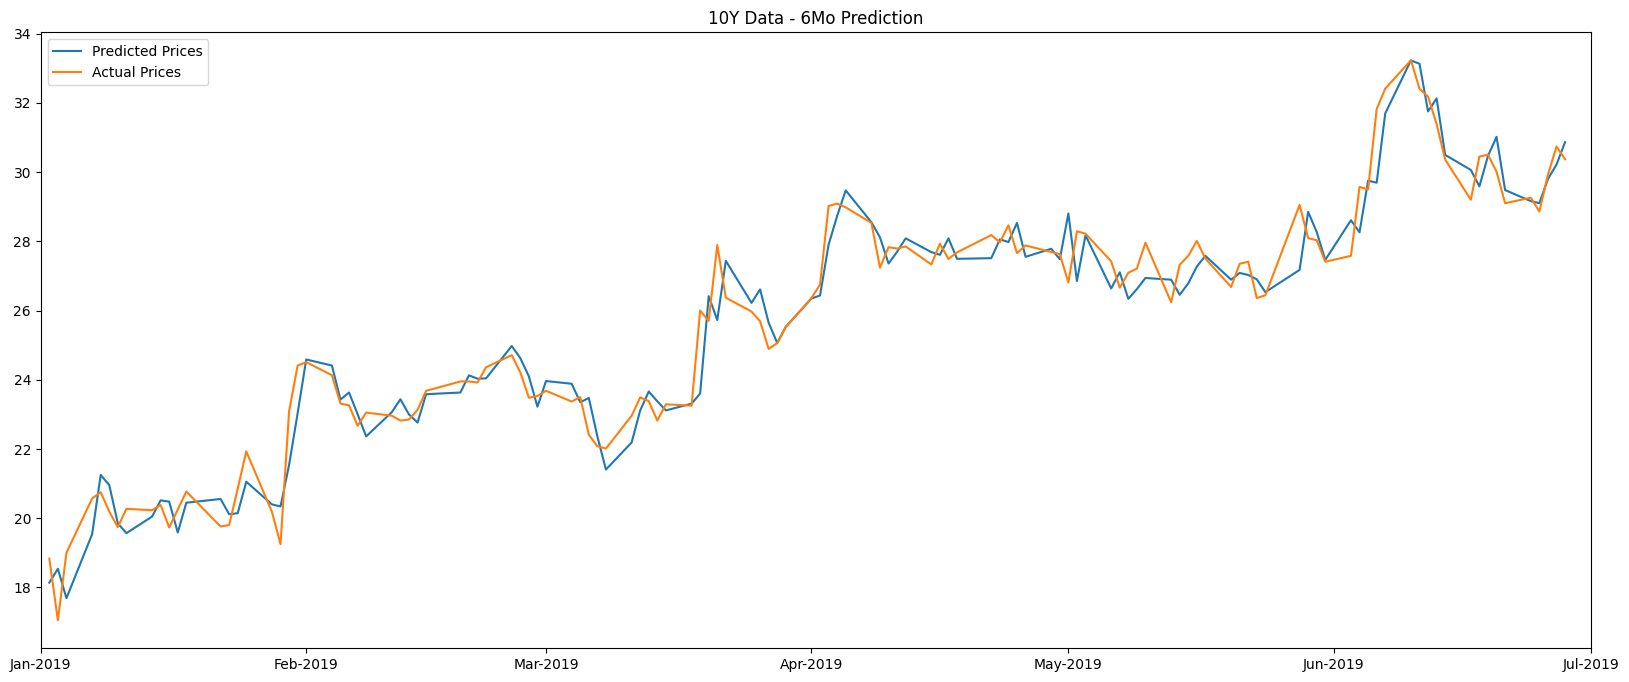

In [13]:
y_pred, y_test, r, m, p, t = runGRU1(AMD_train10, AMD_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

# Long Short-Term Memory Networks (LSTMs)

In [14]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint

In [15]:
def runLSTM(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(LSTM(50, input_shape = (1,1), return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    
    filepath = "Best-LSTM.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only = True, mode = "min")
    cb_list = [checkpoint]
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 10, epochs = epochs, callbacks = cb_list)
    
    new_model = load_model("Best-LSTM.hdf5")
    y_pred = new_model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

Epoch 1/100
2516/2516 [==============================] - 9s 3ms/step - loss: 0.0066 - val_loss: 8.3435e-04
Epoch 2/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0012 - val_loss: 1.9077e-04
Epoch 3/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 1.9604e-04
Epoch 4/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 1.4283e-04
Epoch 5/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 8.4730e-04
Epoch 6/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 4.7261e-04
Epoch 7/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 1.9664e-04
Epoch 9/100
2516/2516 [==============================] - 6s 2ms/step - loss: 0.0011 - val_loss: 1.8491e-04
Epoch 10/100
2516/2516 [=================

Epoch 75/100
2516/2516 [==============================] - 6s 2ms/step - loss: 8.5709e-04 - val_loss: 1.7169e-04
Epoch 76/100
2516/2516 [==============================] - 6s 3ms/step - loss: 7.8221e-04 - val_loss: 2.0101e-04
Epoch 77/100
2516/2516 [==============================] - 7s 3ms/step - loss: 9.4679e-04 - val_loss: 2.5689e-04
Epoch 78/100
2516/2516 [==============================] - 7s 3ms/step - loss: 8.6991e-04 - val_loss: 5.2324e-04
Epoch 79/100
2516/2516 [==============================] - 7s 3ms/step - loss: 8.8158e-04 - val_loss: 0.0017
Epoch 80/100
2516/2516 [==============================] - 6s 3ms/step - loss: 9.2210e-04 - val_loss: 4.7052e-04
Epoch 81/100
2516/2516 [==============================] - 6s 3ms/step - loss: 8.8107e-04 - val_loss: 1.4848e-04
Epoch 82/100
2516/2516 [==============================] - 6s 2ms/step - loss: 8.3959e-04 - val_loss: 4.0901e-04
Epoch 83/100
2516/2516 [==============================] - 6s 2ms/step - loss: 8.9344e-04 - val_loss: 1.4324e

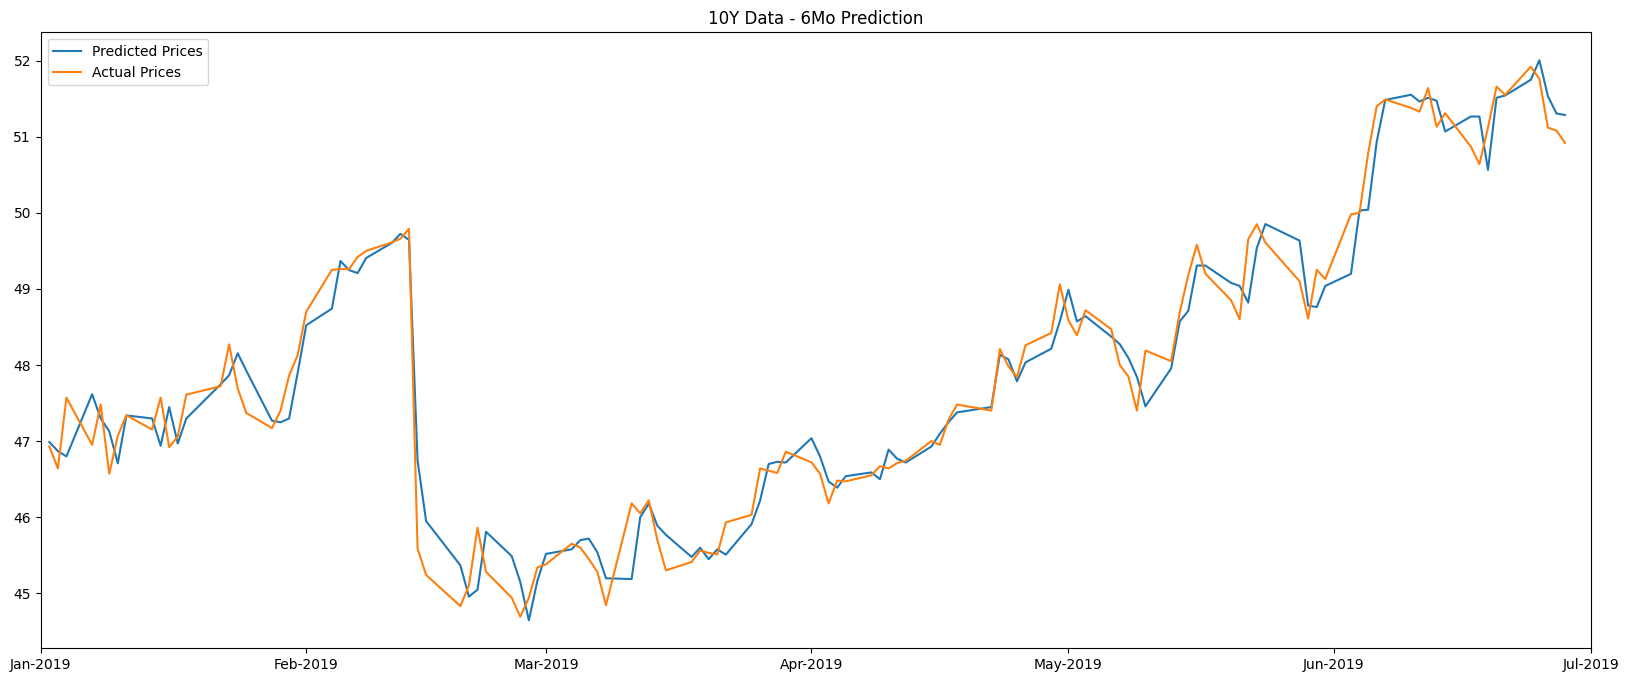

In [20]:
y_pred, y_test, r, m, p, t = runLSTM(KO_train10, KO_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/100
252/252 [==============================] - 10s 15ms/step - loss: 0.0418 - val_loss: 0.0056
Epoch 2/100
252/252 [==============================] - 2s 7ms/step - loss: 0.0049 - val_loss: 2.5254e-04
Epoch 3/100
252/252 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 1.7204e-04
Epoch 4/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 2.5156e-04
Epoch 5/100
252/252 [==============================] - 2s 7ms/step - loss: 0.0015 - val_loss: 1.7538e-04
Epoch 6/100
252/252 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 1.7274e-04
Epoch 7/100
252/252 [==============================] - 2s 6ms/step - loss: 9.6758e-04 - val_loss: 1.8999e-04
Epoch 8/100
252/252 [==============================] - 2s 7ms/step - loss: 9.3658e-04 - val_loss: 2.3318e-04
Epoch 9/100
252/252 [==============================] - 2s 6ms/step - loss: 8.4601e-04 - val_loss: 1.9170e-04
Epoch 10/100
252/252 [=======================

Epoch 76/100
252/252 [==============================] - 2s 6ms/step - loss: 8.5315e-04 - val_loss: 5.6796e-04
Epoch 77/100
252/252 [==============================] - 2s 6ms/step - loss: 8.0079e-04 - val_loss: 2.4724e-04
Epoch 78/100
252/252 [==============================] - 2s 6ms/step - loss: 8.3979e-04 - val_loss: 2.0167e-04
Epoch 79/100
252/252 [==============================] - 2s 6ms/step - loss: 8.5953e-04 - val_loss: 2.1634e-04
Epoch 80/100
252/252 [==============================] - 2s 6ms/step - loss: 8.1114e-04 - val_loss: 2.4343e-04
Epoch 81/100
252/252 [==============================] - 2s 6ms/step - loss: 7.9649e-04 - val_loss: 2.3559e-04
Epoch 82/100
252/252 [==============================] - 2s 6ms/step - loss: 8.1704e-04 - val_loss: 5.7500e-04
Epoch 83/100
252/252 [==============================] - 2s 7ms/step - loss: 8.2110e-04 - val_loss: 1.6207e-04
Epoch 84/100
252/252 [==============================] - 2s 6ms/step - loss: 8.6630e-04 - val_loss: 2.3459e-04
Epoch 85/1

Epoch 45/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 46/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 47/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 48/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 49/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 50/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 9.3641e-04
Epoch 51/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 52/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 8.9506e-04
Epoch 53/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 9.5399e-04
Epoch 54/100
126/126 [==============================] - 1s 7ms/step - 

126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 94/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 95/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 9.6848e-04
Epoch 96/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 97/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 9.7771e-04
Epoch 98/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 7.4094e-04
Epoch 99/100
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 100/100
4/4 [==============================] - 1s 4ms/step
5Y Data - 6Mo Prediction
RMSE: 0.36228801700885993
MAPE: 0.5797292130634644
POC: 54.03225806451613
Execution Time: 96.17066884040833 seconds 



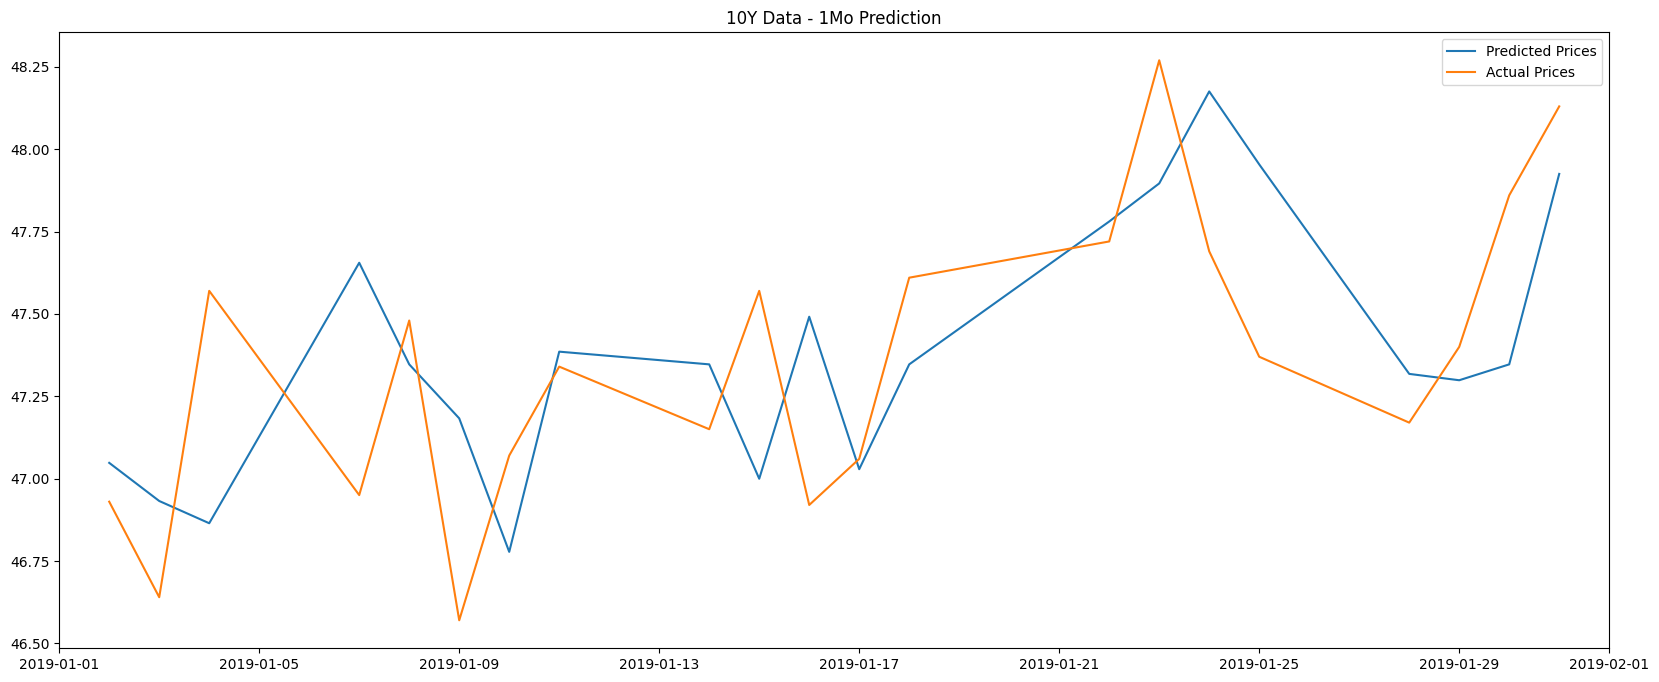

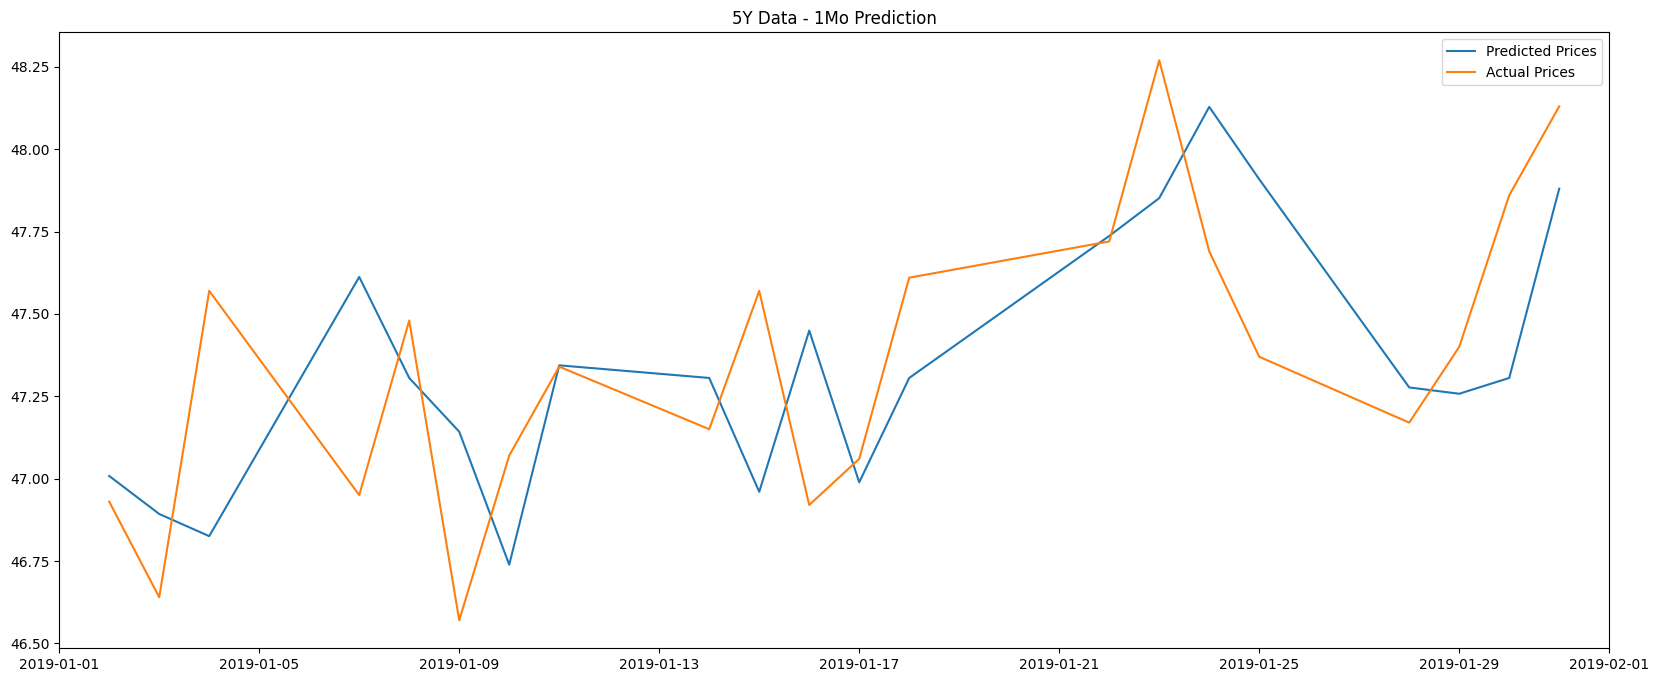

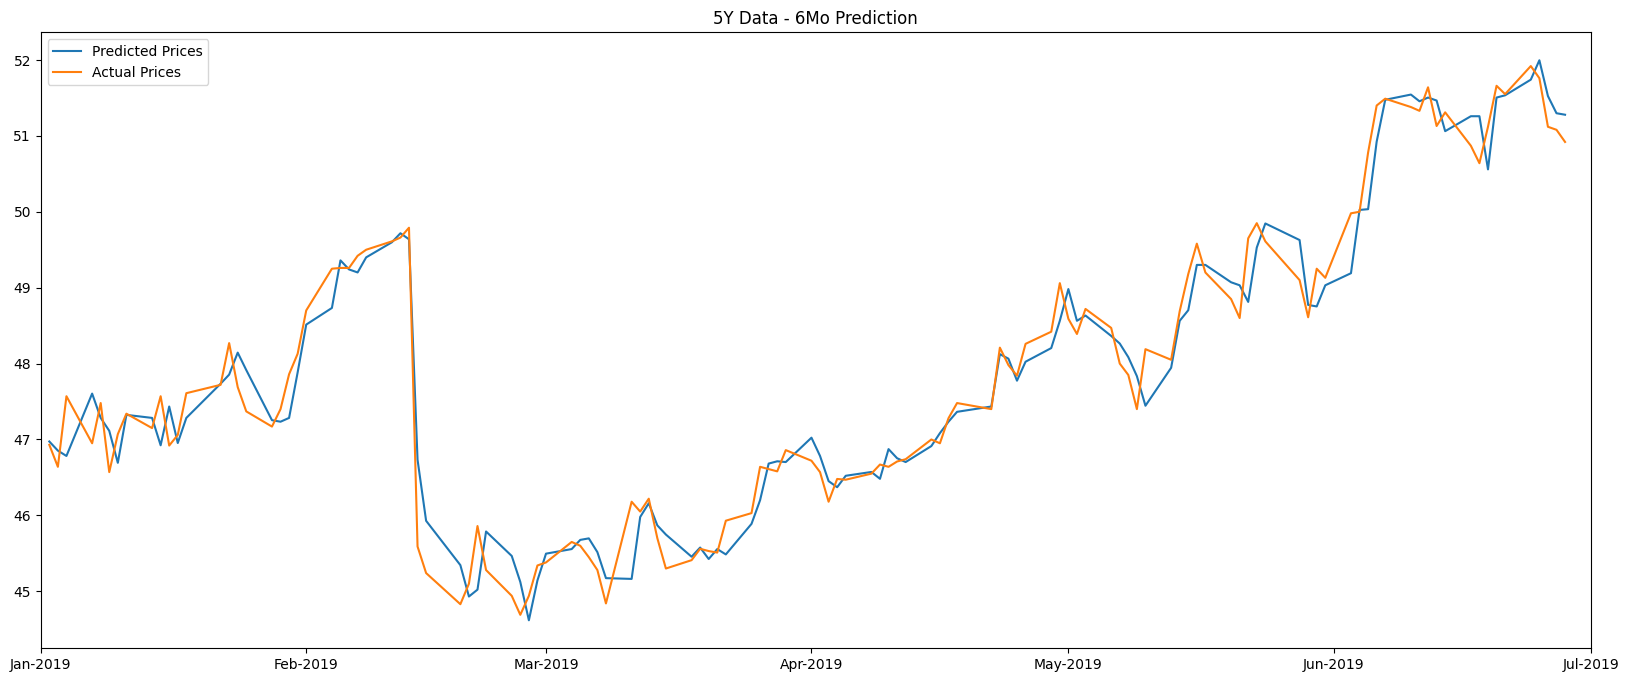

In [21]:
y_pred, y_test, r, m, p, t = runLSTM(KO_train10, KO_test1, 100)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runLSTM(KO_train5, KO_test1, 100)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runLSTM(KO_train5, KO_test6, 100)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

### AMD Stock

Epoch 1/100
252/252 [==============================] - 4s 5ms/step - loss: 0.0072 - val_loss: 6.0390e-04
Epoch 2/100
252/252 [==============================] - 1s 4ms/step - loss: 6.3554e-04 - val_loss: 6.6059e-04
Epoch 3/100
252/252 [==============================] - 1s 4ms/step - loss: 5.5682e-04 - val_loss: 6.2453e-04
Epoch 4/100
252/252 [==============================] - 1s 4ms/step - loss: 6.2605e-04 - val_loss: 0.0014
Epoch 5/100
252/252 [==============================] - 1s 4ms/step - loss: 5.5412e-04 - val_loss: 6.0230e-04
Epoch 6/100
252/252 [==============================] - 1s 3ms/step - loss: 4.9798e-04 - val_loss: 0.0012
Epoch 7/100
252/252 [==============================] - 1s 4ms/step - loss: 5.4155e-04 - val_loss: 7.5751e-04
Epoch 8/100
252/252 [==============================] - 1s 3ms/step - loss: 5.4149e-04 - val_loss: 9.1180e-04
Epoch 9/100
252/252 [==============================] - 1s 3ms/step - loss: 5.3288e-04 - val_loss: 0.0013
Epoch 10/100
252/252 [=============

Epoch 77/100
252/252 [==============================] - 1s 4ms/step - loss: 5.3074e-04 - val_loss: 0.0013
Epoch 78/100
252/252 [==============================] - 1s 4ms/step - loss: 4.4882e-04 - val_loss: 5.7481e-04
Epoch 79/100
252/252 [==============================] - 1s 4ms/step - loss: 4.3018e-04 - val_loss: 5.9904e-04
Epoch 80/100
252/252 [==============================] - 1s 4ms/step - loss: 5.0070e-04 - val_loss: 7.4102e-04
Epoch 81/100
252/252 [==============================] - 1s 4ms/step - loss: 5.3075e-04 - val_loss: 7.7180e-04
Epoch 82/100
252/252 [==============================] - 1s 4ms/step - loss: 5.1029e-04 - val_loss: 9.1027e-04
Epoch 83/100
252/252 [==============================] - 1s 4ms/step - loss: 4.6127e-04 - val_loss: 0.0010
Epoch 84/100
252/252 [==============================] - 1s 4ms/step - loss: 5.1076e-04 - val_loss: 5.6938e-04
Epoch 85/100
252/252 [==============================] - 1s 4ms/step - loss: 4.9244e-04 - val_loss: 7.8333e-04
Epoch 86/100
252/2

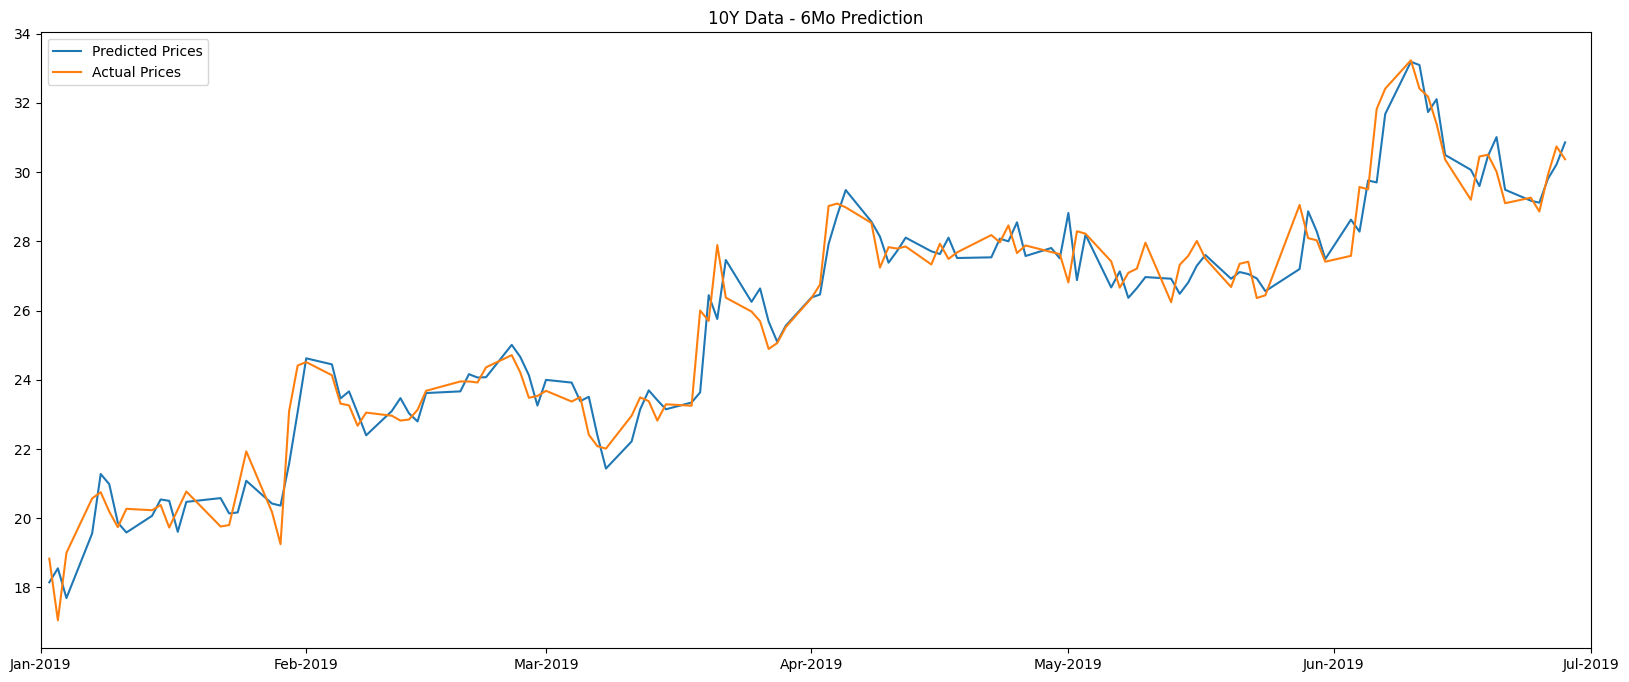

In [17]:
y_pred, y_test, r, m, p, t = runLSTM(AMD_train10, AMD_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

# Stacked LSTM

In [18]:
def runStackedLSTM(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(LSTM(50, input_shape = (1,1), return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(25, input_shape = (1,1), return_sequences = False ))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    
    filepath = "Best-Stacked-LSTM.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only = True, mode = "min")
    cb_list = [checkpoint]
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 10, epochs = epochs, callbacks = cb_list)
    
    new_model = load_model("Best-Stacked-LSTM.hdf5")
    y_pred = new_model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

Epoch 1/100
252/252 [==============================] - 7s 9ms/step - loss: 0.0525 - val_loss: 0.0032
Epoch 2/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 2.0648e-04
Epoch 3/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 1.7125e-04
Epoch 4/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 1.6983e-04
Epoch 5/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 4.8267e-04
Epoch 6/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 2.1498e-04
Epoch 7/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 1.4986e-04
Epoch 8/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 1.3520e-04
Epoch 9/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 7.1065e-04
Epoch 10/100
252/252 [==============================] - 1s 

Epoch 79/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 80/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 81/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 82/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 83/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 7.8519e-04
Epoch 84/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 85/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 86/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 87/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 88/100
252/252 [==============================] - 1s 5ms/step - loss: 0.

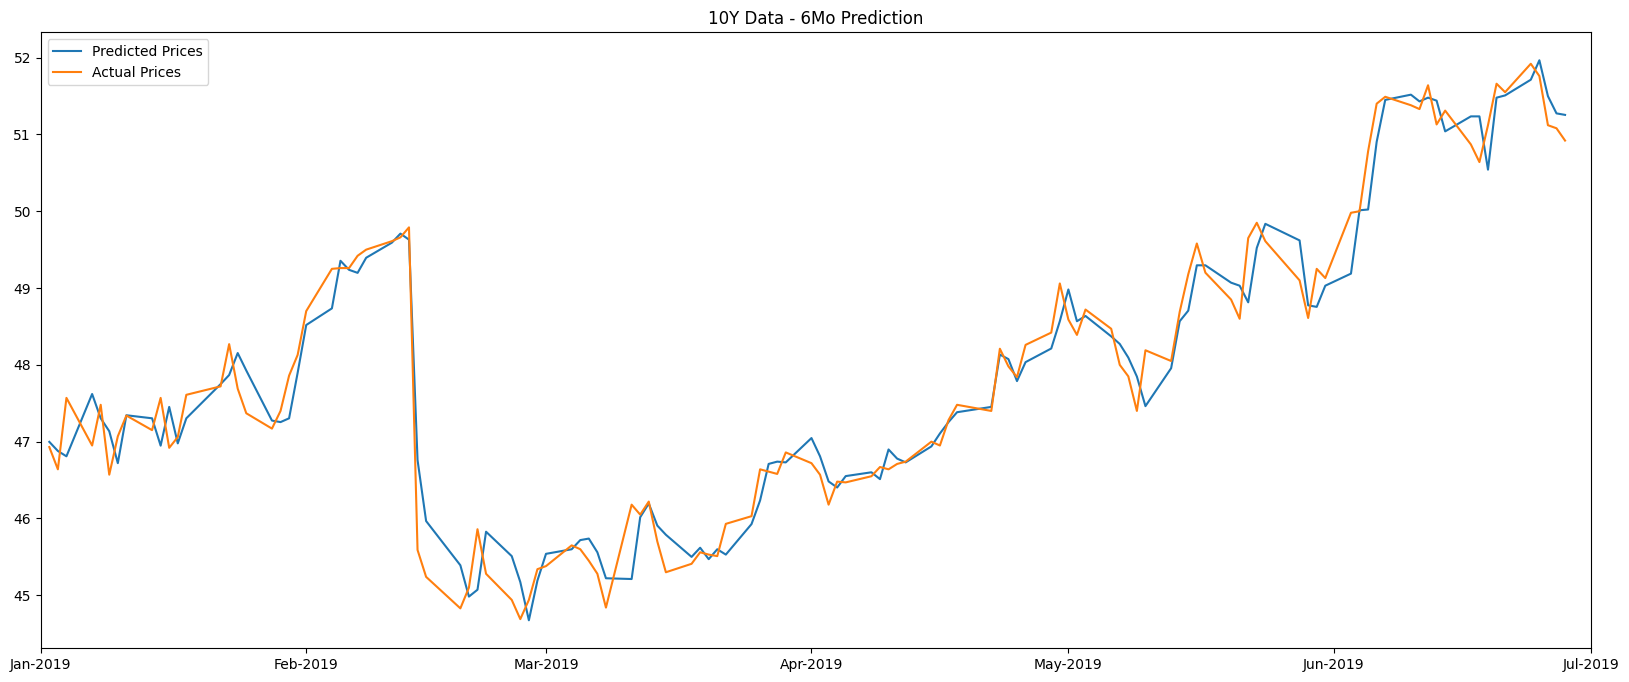

In [46]:
y_pred, y_test, r, m, p, t = runStackedLSTM(KO_train10, KO_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

In [24]:
# Actual execution time, previous time was not comparable as a GPU was used. 

y_pred, y_test, r, m, p, t = runStackedLSTM(KO_train10, KO_test6, 100)
print("10Y Data - 6Mo Prediction")
#print("RMSE:", r)
#print("MAPE:", m)
#print("POC:", p)
print("Execution Time:", t, "seconds \n")
#plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/100
252/252 [==============================] - 14s 18ms/step - loss: 0.0610 - val_loss: 0.0014
Epoch 2/100
252/252 [==============================] - 3s 10ms/step - loss: 0.0066 - val_loss: 1.9038e-04
Epoch 3/100
252/252 [==============================] - 3s 10ms/step - loss: 0.0037 - val_loss: 1.9358e-04
Epoch 4/100
252/252 [==============================] - 3s 10ms/step - loss: 0.0032 - val_loss: 1.9818e-04
Epoch 5/100
252/252 [==============================] - 2s 10ms/step - loss: 0.0027 - val_loss: 3.7465e-04
Epoch 6/100
252/252 [==============================] - 2s 10ms/step - loss: 0.0027 - val_loss: 4.3222e-04
Epoch 7/100
252/252 [==============================] - 3s 10ms/step - loss: 0.0025 - val_loss: 1.3665e-04
Epoch 8/100
252/252 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 2.4574e-04
Epoch 9/100
252/252 [==============================] - 3s 10ms/step - loss: 0.0026 - val_loss: 1.8962e-04
Epoch 10/100
252/252 [============================

Epoch 1/100
252/252 [==============================] - 6s 7ms/step - loss: 0.0511 - val_loss: 0.0020
Epoch 2/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 5.5713e-04
Epoch 3/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0038 - val_loss: 1.8078e-04
Epoch 4/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 2.8245e-04
Epoch 5/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 2.0768e-04
Epoch 6/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 4.6795e-04
Epoch 8/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 2.5908e-04
Epoch 9/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 7.9492e-04
Epoch 10/100
252/252 [==============================] - 1s 3ms/

Epoch 79/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 6.4666e-04
Epoch 80/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 3.2033e-04
Epoch 81/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 82/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 8.9115e-04
Epoch 83/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 84/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 1.7799e-04
Epoch 85/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 5.9016e-04
Epoch 86/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 87/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 88/100
252/252 [==============================] - 1s 4ms

Epoch 34/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 35/100
126/126 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 36/100
126/126 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 37/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 38/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 39/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 40/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 41/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 8.3426e-04
Epoch 42/100
126/126 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 43/100
126/126 [==============================] - 1s 6ms/step - loss: 0.

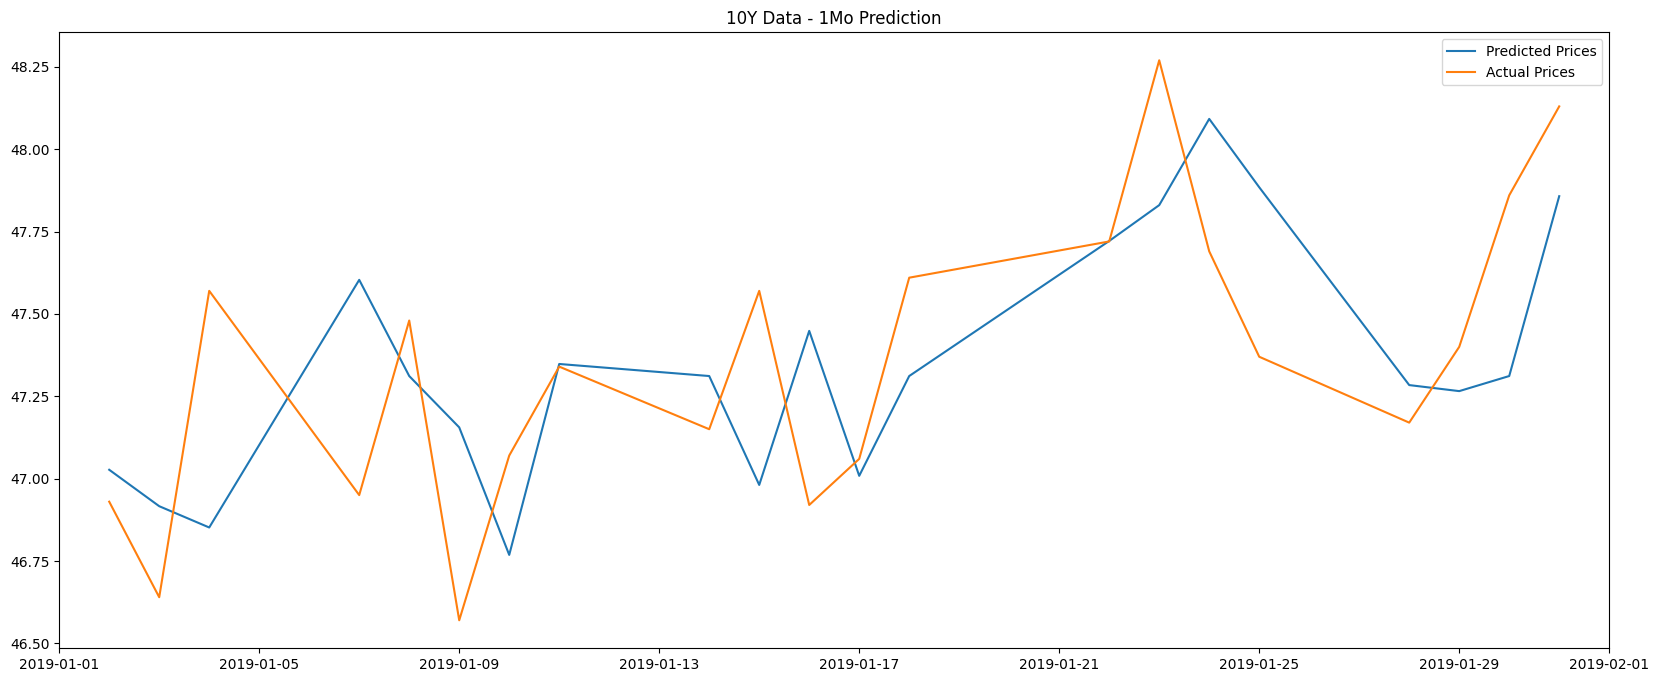

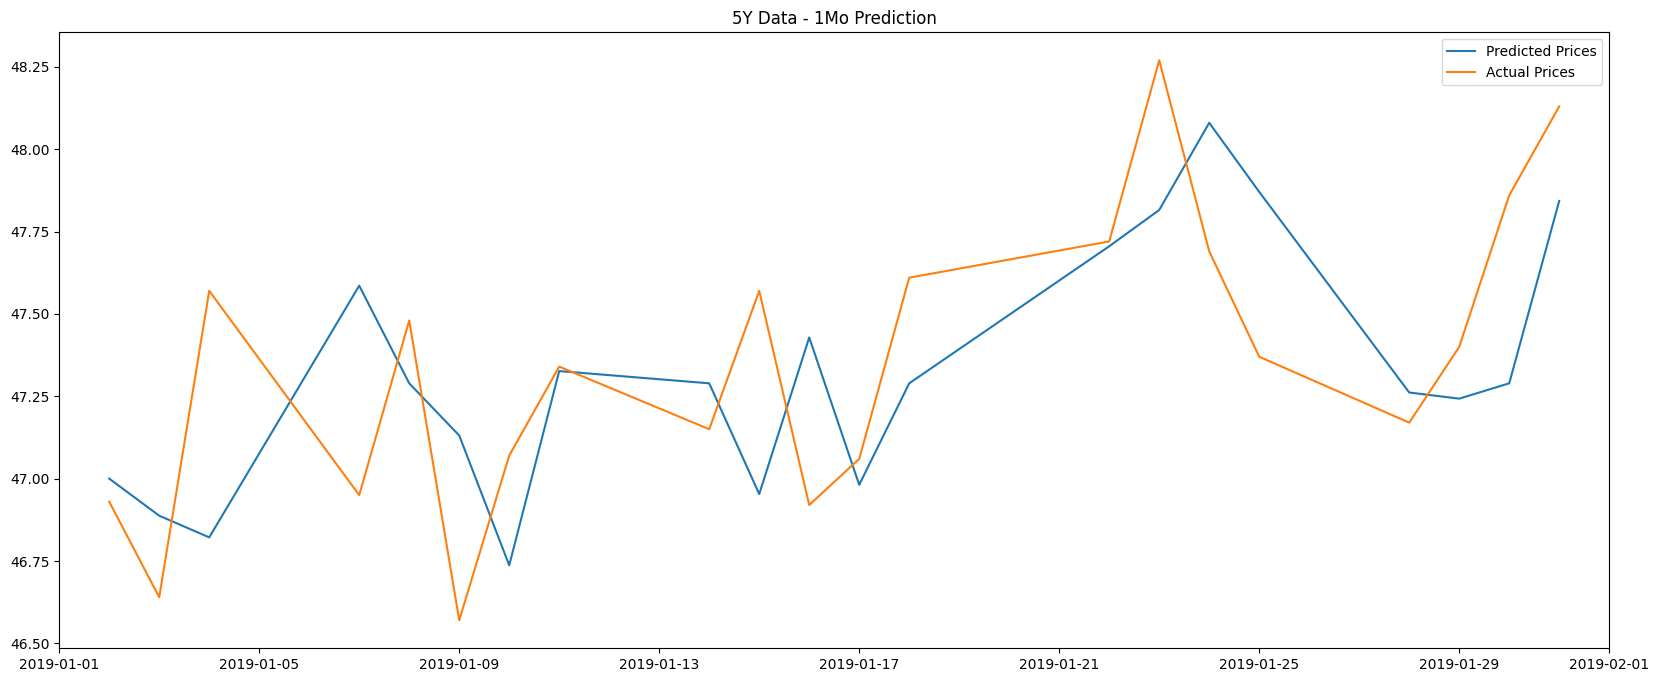

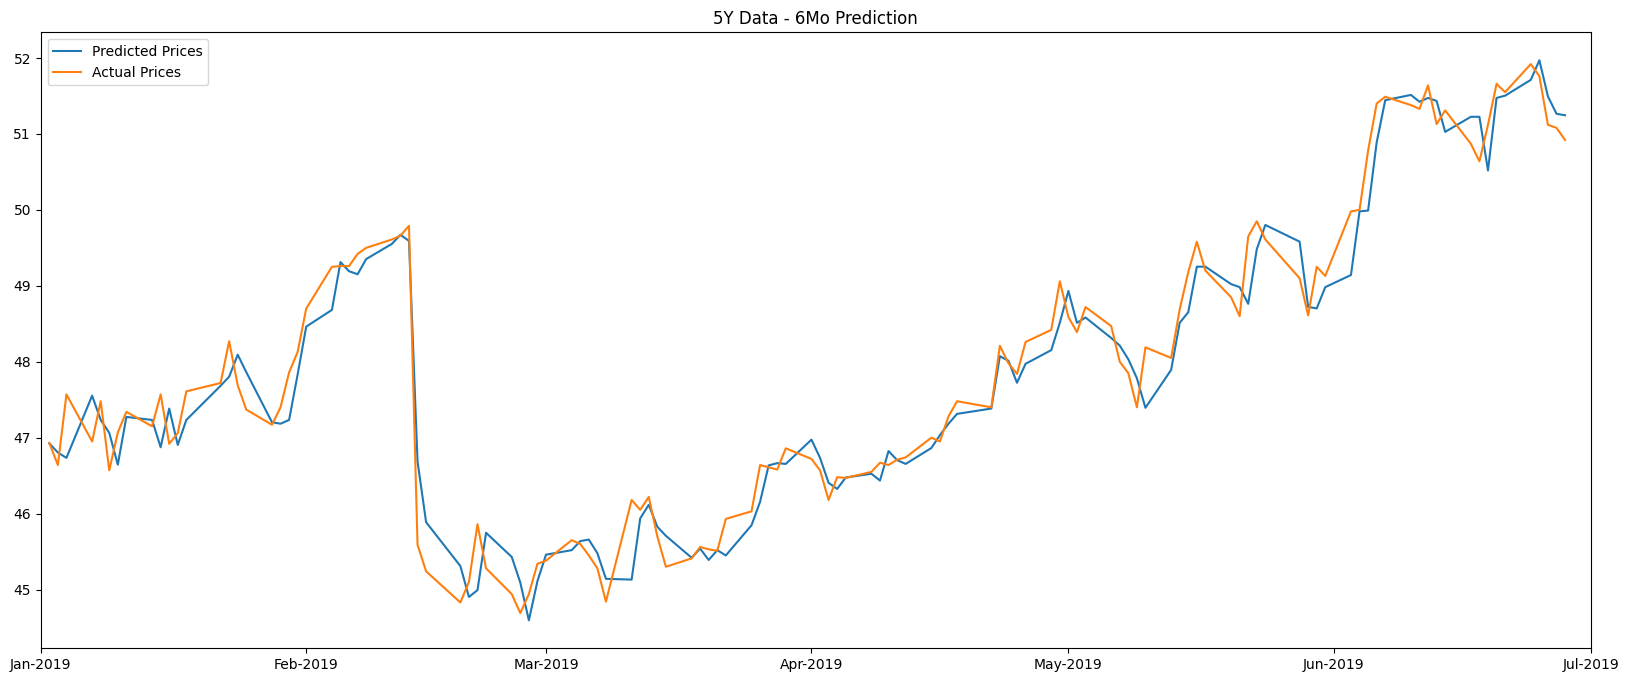

In [34]:
y_pred, y_test, r, m, p, t = runStackedLSTM(KO_train10, KO_test1, 100)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runStackedLSTM(KO_train5, KO_test1, 100)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runStackedLSTM(KO_train5, KO_test6, 100)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

### AMD Stock

Epoch 1/100
252/252 [==============================] - 7s 9ms/step - loss: 0.0135 - val_loss: 7.6890e-04
Epoch 2/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 7.9920e-04
Epoch 3/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 9.3591e-04
Epoch 5/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0067
Epoch 8/100
252/252 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 5.6422e-04
Epoch 9/100
252/252 [==============================] - 2s 6ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 10/100
252/252 [==============================] - 1s 6ms/step - loss:

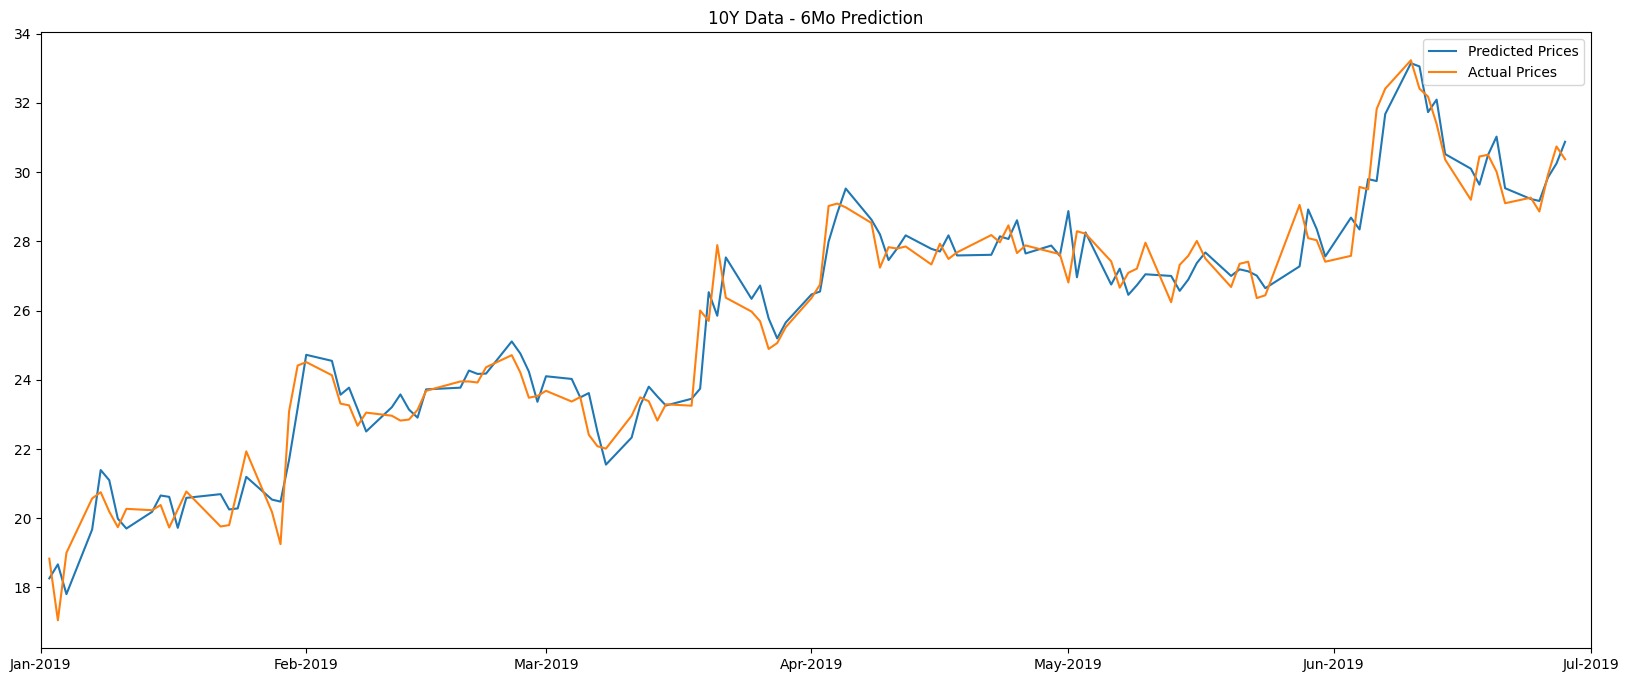

In [27]:
y_pred, y_test, r, m, p, t = runStackedLSTM(AMD_train10, AMD_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

# Convolutional Neural Networks (CNNs)

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Conv1D

In [21]:
def runCNN(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(Conv2D(50, kernel_size = (1, 1), activation="relu", input_shape = (1,1,1)))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')

    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 1, epochs = epochs)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

Epoch 1/10
2516/2516 [==============================] - 4s 1ms/step - loss: 0.0119 - val_loss: 4.1551e-04
Epoch 2/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0080 - val_loss: 2.4418e-04
Epoch 3/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0076 - val_loss: 4.1273e-04
Epoch 4/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0077 - val_loss: 2.9852e-04
Epoch 5/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0078 - val_loss: 8.0318e-04
Epoch 6/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0077 - val_loss: 1.3369e-04
Epoch 7/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0077 - val_loss: 1.3286e-04
Epoch 8/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0079 - val_loss: 5.1244e-04
Epoch 9/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 10/10
4/4 [==============================] -

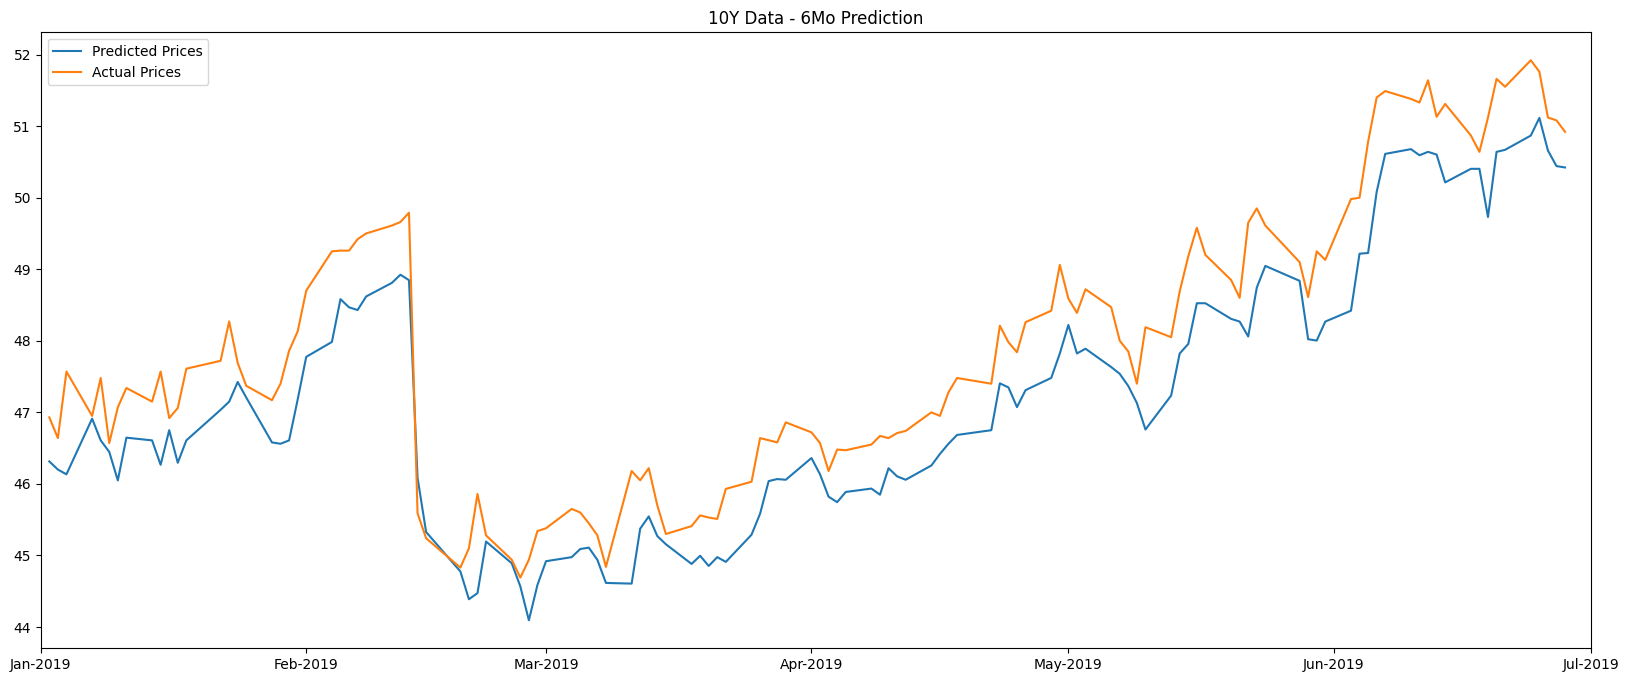

In [22]:
y_pred, y_test, r, m, p, t = runCNN(KO_train10, KO_test6, 10)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/10
2516/2516 [==============================] - 4s 1ms/step - loss: 0.0108 - val_loss: 1.6631e-04
Epoch 2/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0083 - val_loss: 9.0524e-04
Epoch 3/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 4/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 5/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0085 - val_loss: 2.6707e-04
Epoch 6/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 7/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0082 - val_loss: 8.0622e-04
Epoch 8/10
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 9/10
2516/2516 [==============================] - 4s 1ms/step - loss: 0.0081 - val_loss: 5.4182e-04
Epoch 10/10
1/1 [==============================] - 0s 106ms/st

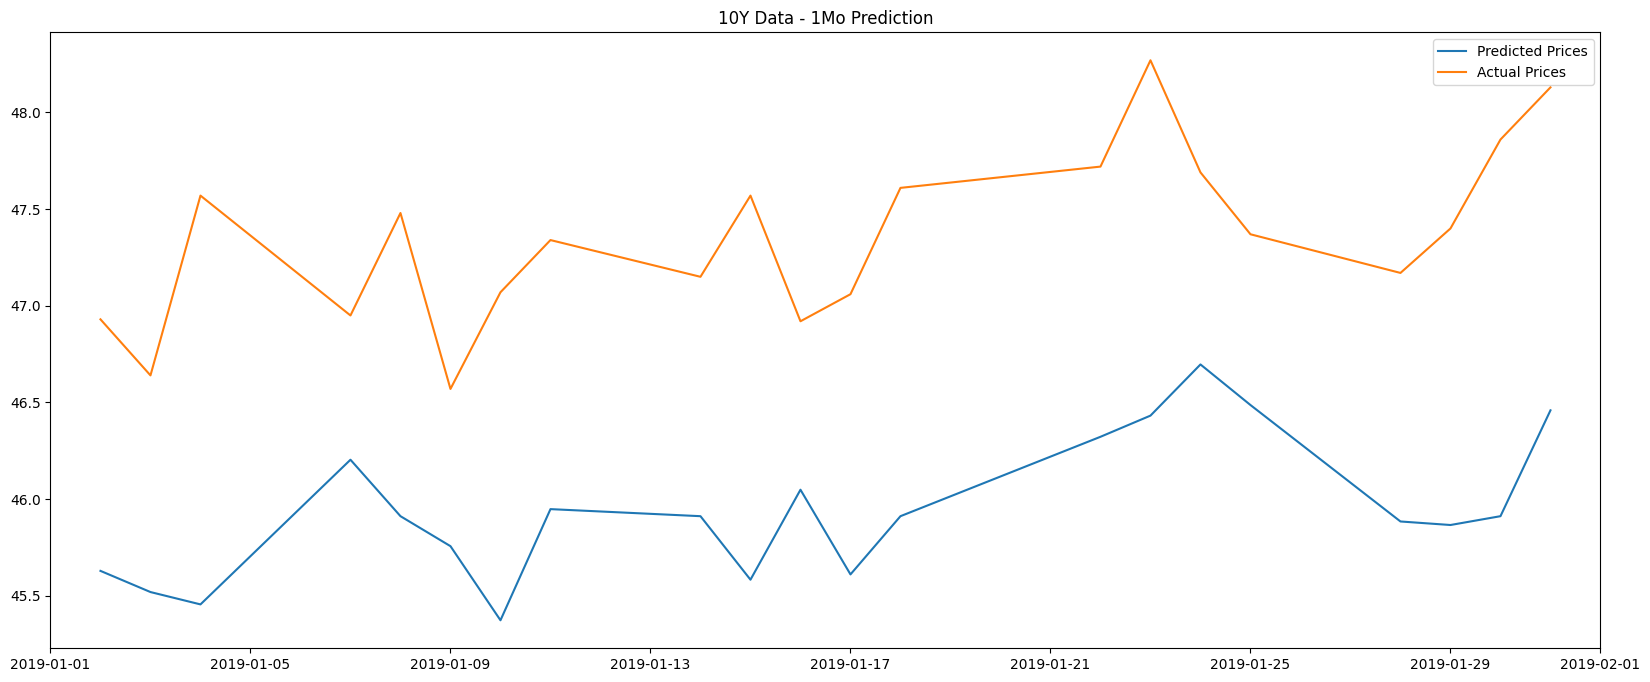

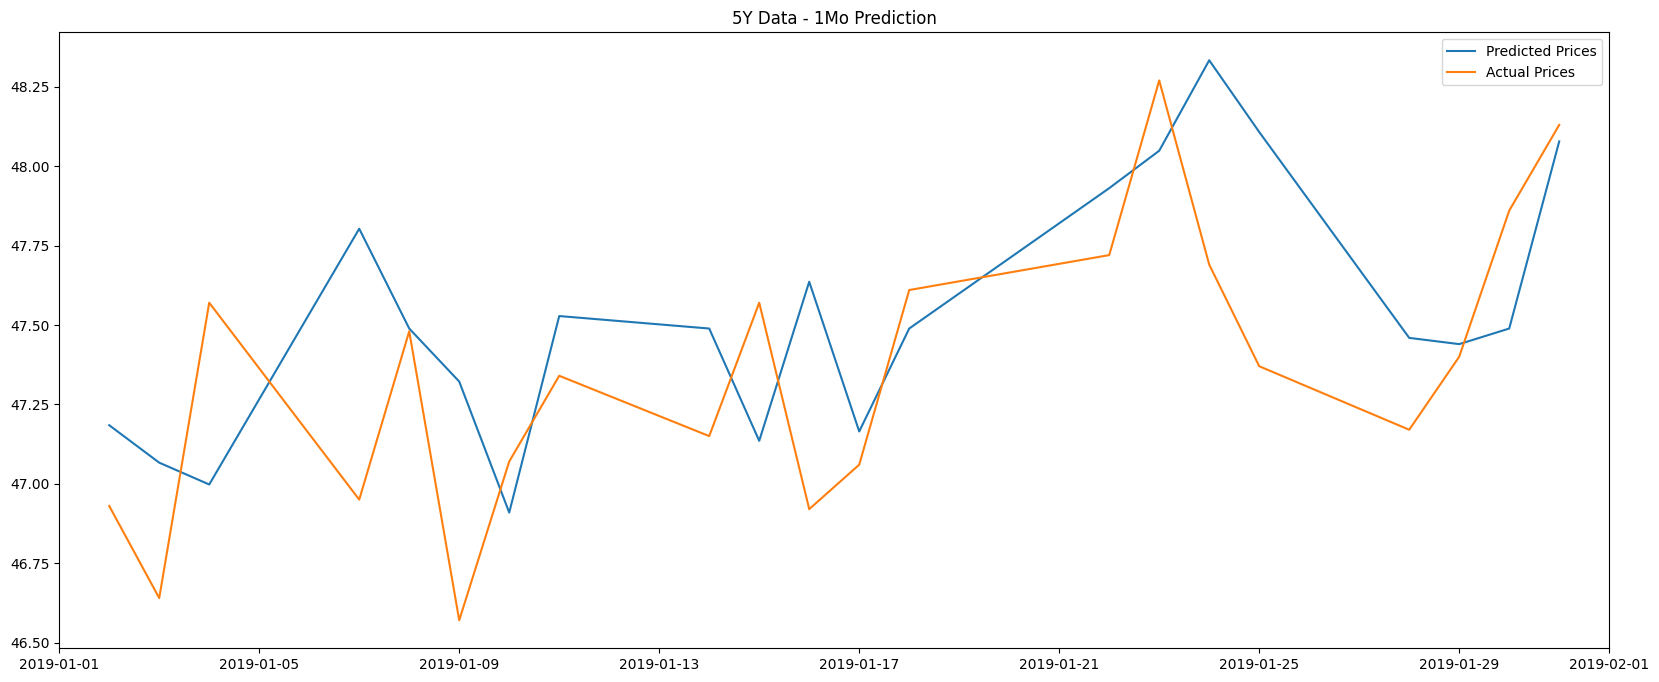

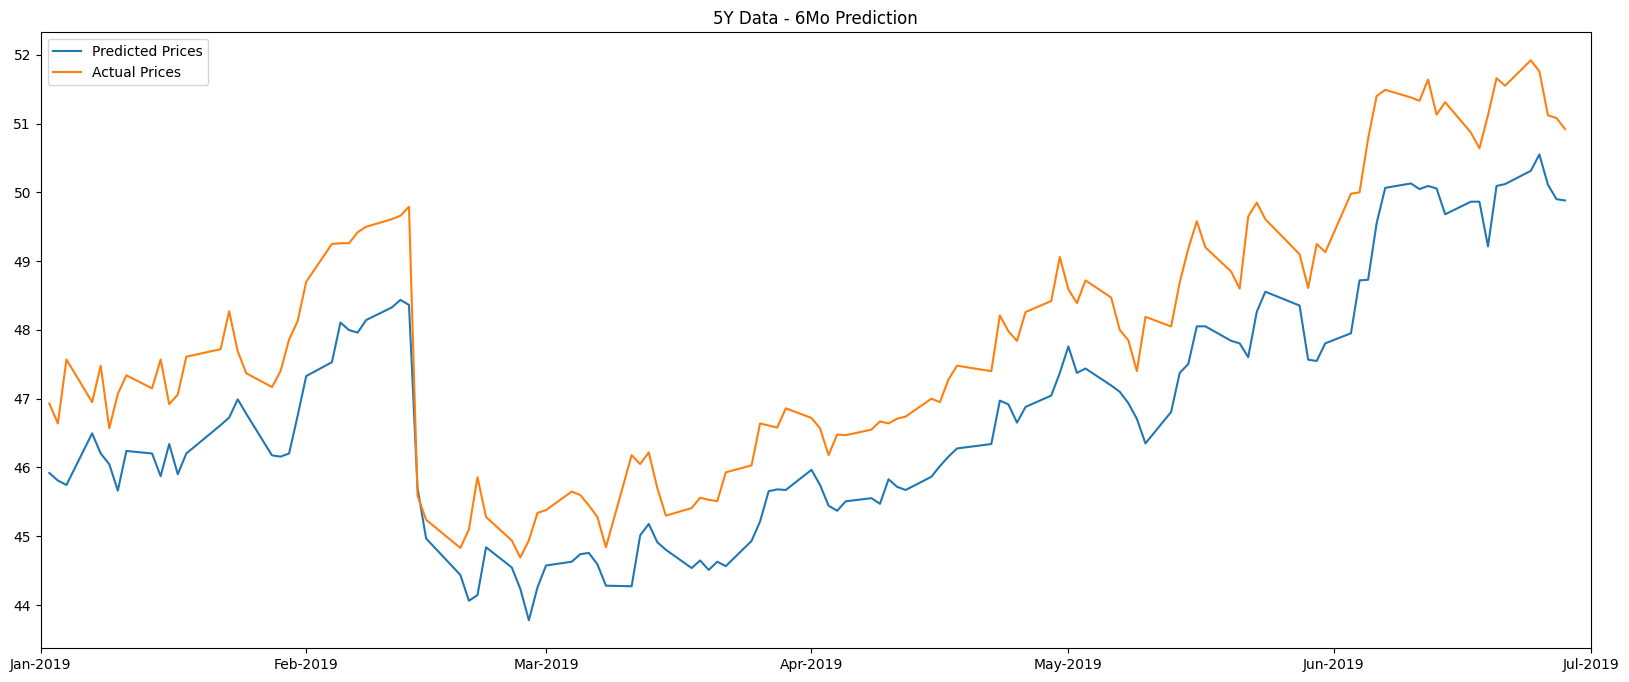

In [33]:
y_pred, y_test, r, m, p, t = runCNN(KO_train10, KO_test1, 10)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runCNN(KO_train5, KO_test1, 10)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runCNN(KO_train5, KO_test6, 10)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

# CNN-LSTM

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, LSTM, Flatten, Reshape

In [40]:
def runCNNLSTM(train, test, epochs):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = Sequential()
    model.add(Conv2D(50, kernel_size = 1, activation="relu", input_shape = (1,1,1)))
    model.add(Reshape((1, 50)))
    model.add(LSTM(50, return_sequences = False ))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')

    filepath = "Best-CNN-LSTM.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only = True, mode = "min")
    cb_list = [checkpoint]
    
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), batch_size = 10, epochs = epochs, callbacks = cb_list)
    
    new_model = load_model("Best-CNN-LSTM.hdf5")
    y_pred = new_model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

Epoch 1/100
252/252 [==============================] - 3s 4ms/step - loss: 0.0320 - val_loss: 2.9419e-04
Epoch 2/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 3.4297e-04
Epoch 3/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 1.9966e-04
Epoch 4/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 1.7113e-04
Epoch 5/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 2.0449e-04
Epoch 6/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 9.7877e-04
Epoch 7/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 1.3590e-04
Epoch 8/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 1.3461e-04
Epoch 9/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 3.0433e-04
Epoch 10/100
252/252 [==============================] -

Epoch 79/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 1.7040e-04
Epoch 80/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 3.4306e-04
Epoch 81/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 2.6328e-04
Epoch 82/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 1.5442e-04
Epoch 83/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 1.7388e-04
Epoch 84/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 85/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 2.7078e-04
Epoch 86/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 4.8911e-04
Epoch 87/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 1.4202e-04
Epoch 88/100
252/252 [============================

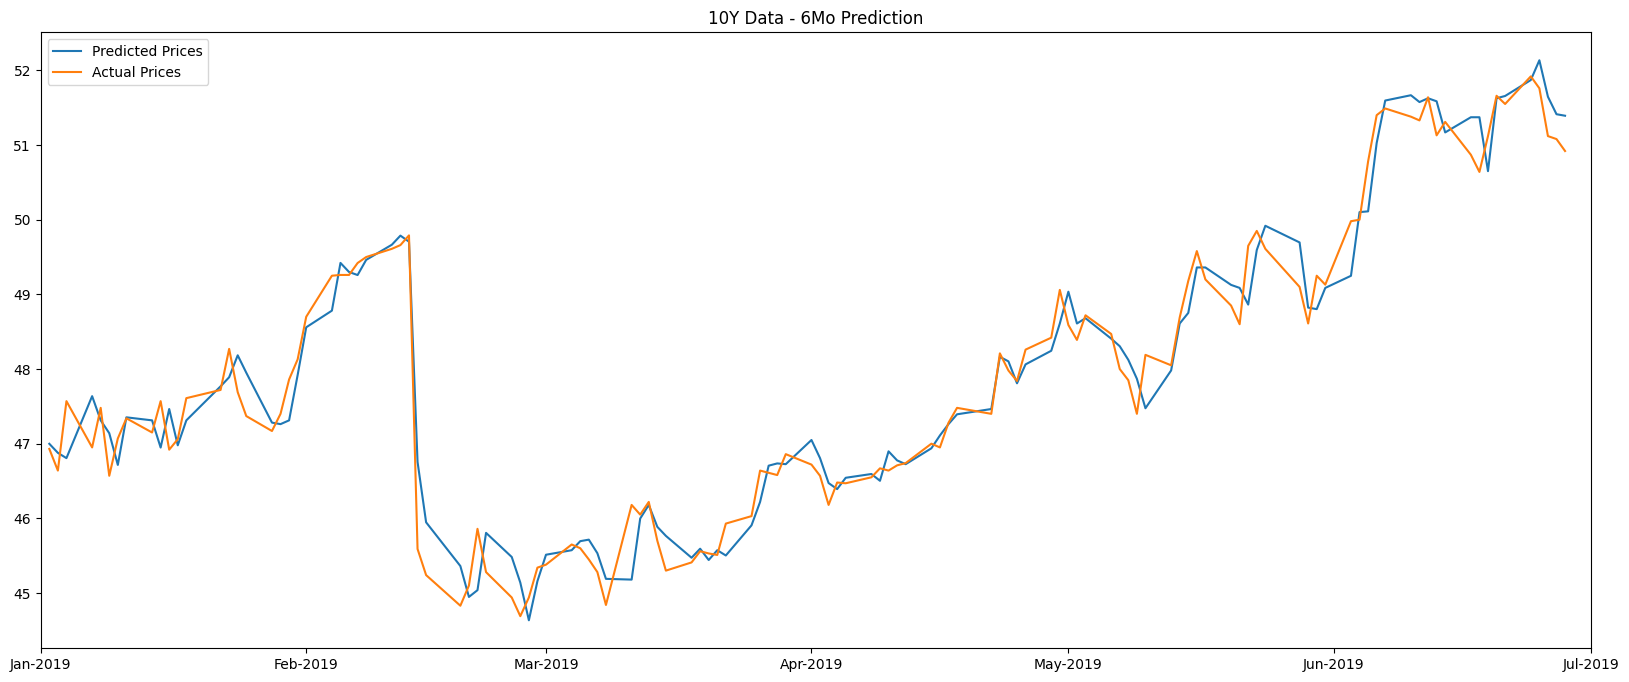

In [88]:
y_pred, y_test, r, m, p, t = runCNNLSTM(KO_train10, KO_test6, 100)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

Epoch 1/100
252/252 [==============================] - 4s 5ms/step - loss: 0.0291 - val_loss: 2.5066e-04
Epoch 2/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 6.6953e-04
Epoch 3/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 4.0107e-04
Epoch 4/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 2.1061e-04
Epoch 5/100
252/252 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 1.7643e-04
Epoch 6/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 3.8997e-04
Epoch 7/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 1.6499e-04
Epoch 8/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
252/252 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 2.1494e-04
Epoch 10/100
252/252 [==============================] - 1s 

Epoch 79/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 3.0589e-04
Epoch 80/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 1.6136e-04
Epoch 81/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 1.9444e-04
Epoch 82/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 4.2171e-04
Epoch 83/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 5.1222e-04
Epoch 84/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 2.2759e-04
Epoch 85/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 4.9012e-04
Epoch 86/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 1.5811e-04
Epoch 87/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 8.4085e-04
Epoch 88/100
252/252 [========================

Epoch 34/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 35/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 36/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 37/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 8.4974e-04
Epoch 38/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 39/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 9.3758e-04
Epoch 40/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 41/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss

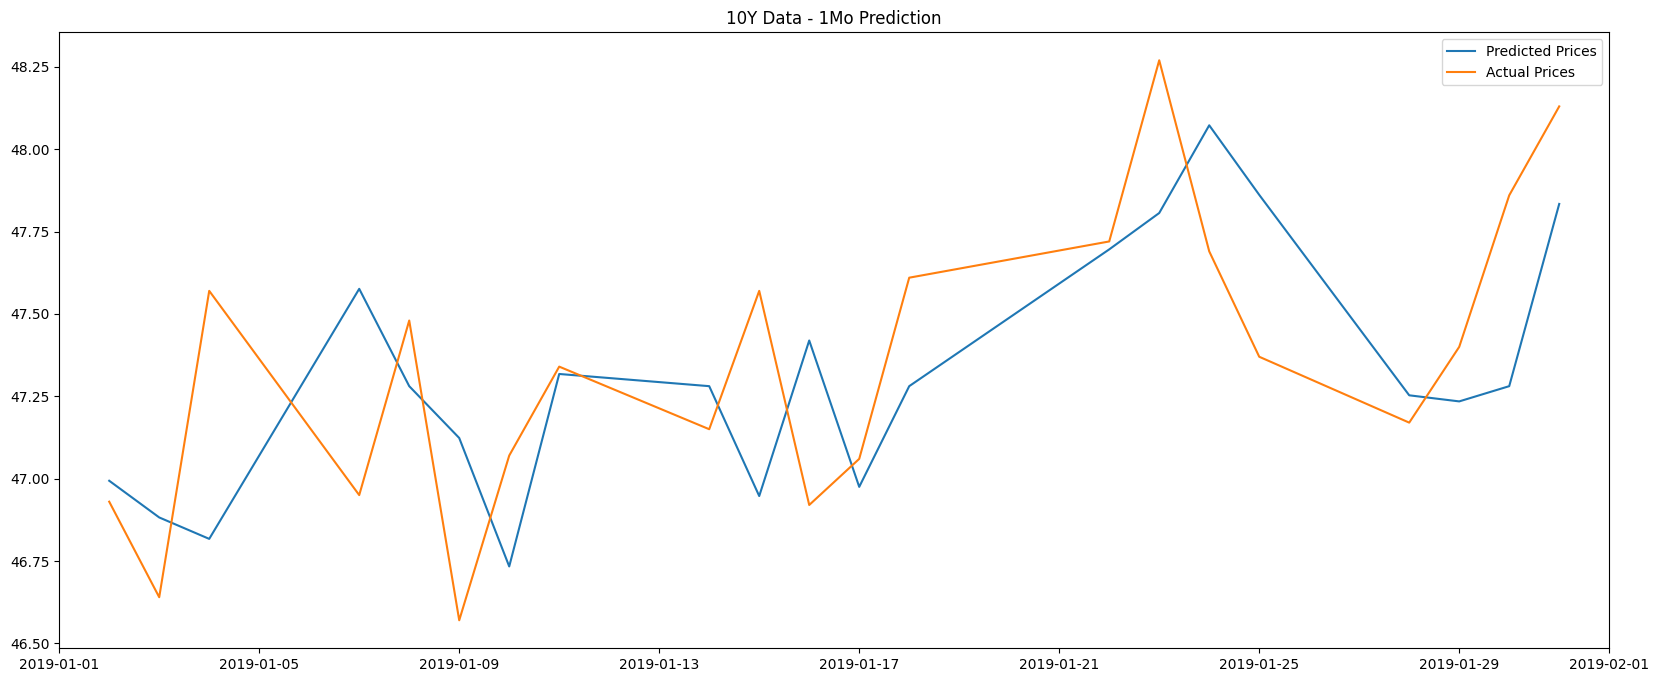

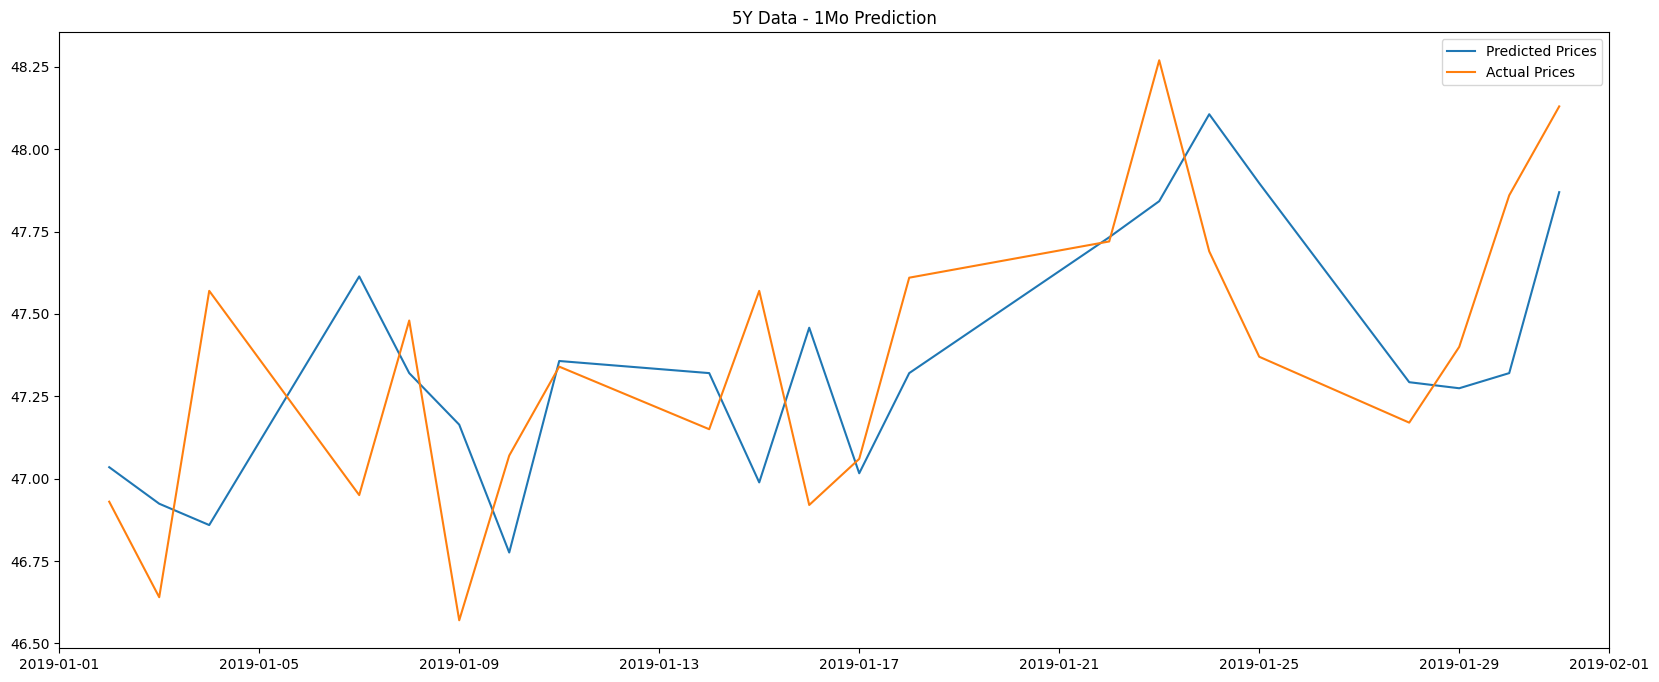

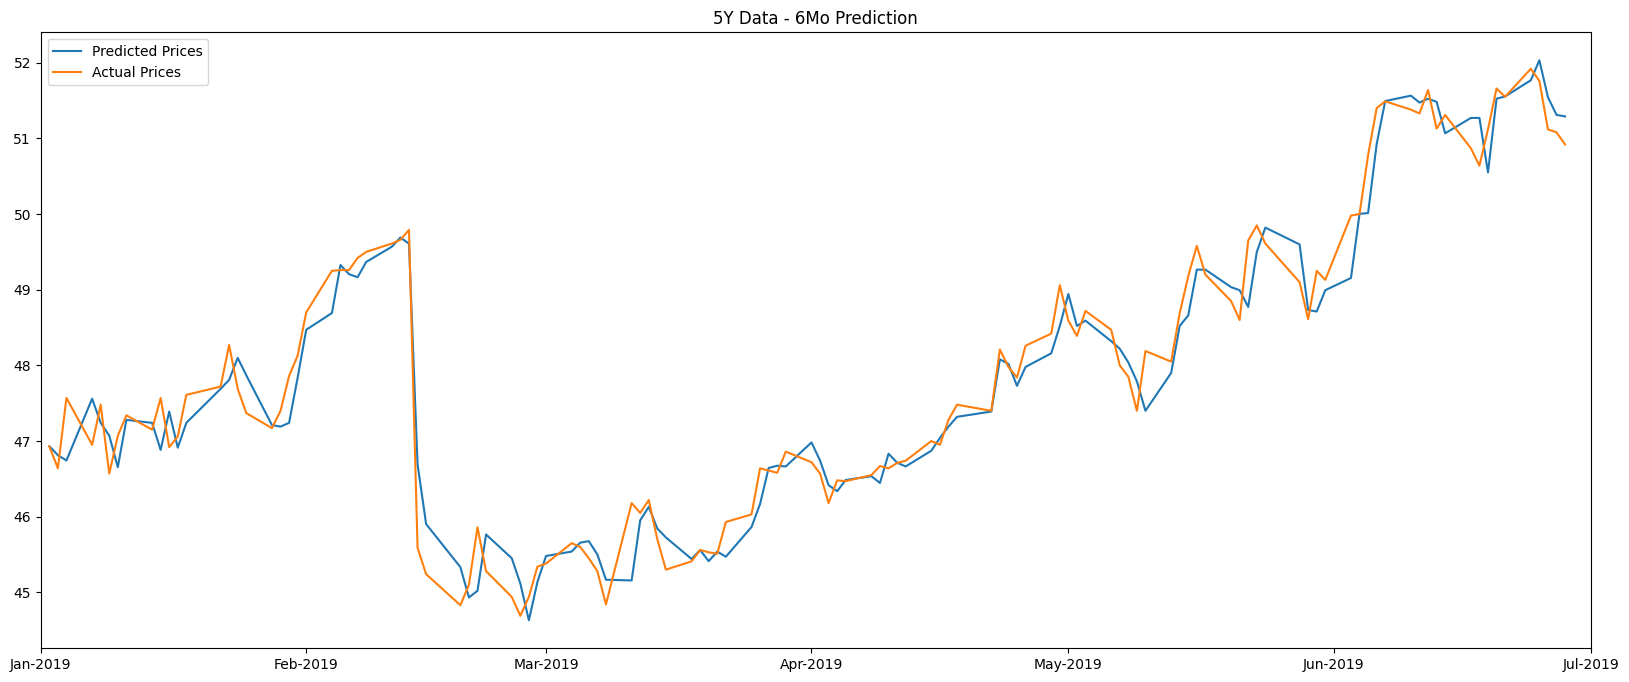

In [90]:
y_pred, y_test, r, m, p, t = runCNNLSTM(KO_train10, KO_test1, 100)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runCNNLSTM(KO_train5, KO_test1, 100)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runCNNLSTM(KO_train5, KO_test6, 100)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

# Echo State Networks (ESNs)

In [20]:
from pyESN import ESN

In [104]:
def runESN_eval(train, test, neurons):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    #X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    #X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = neurons,
          sparsity=0.2,
          random_state=23,
          spectral_radius=1.2,
          noise = 0.005)
    
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

In [108]:
rs = []
ms = []
ps = []
ts = []
neurons = [i for i in range(1, 101)]

for i in neurons:
    y_pred, y_test, r, m, p, t = runESN_eval(KO_train10, KO_test6, i)
    rs.append(r)
    ms.append(m)
    ps.append(p)
    ts.append(t)

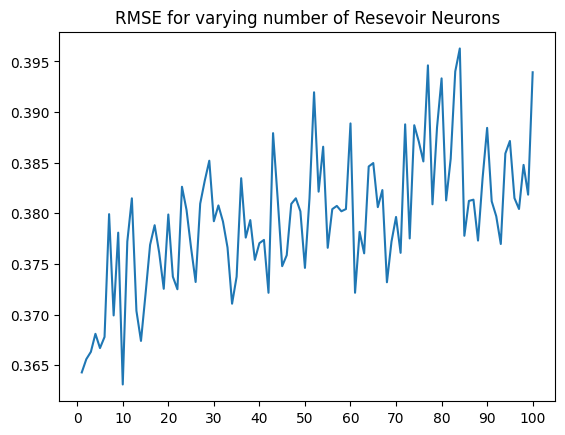

In [112]:
plt.plot(neurons, rs)
plt.title("RMSE for varying number of Resevoir Neurons")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

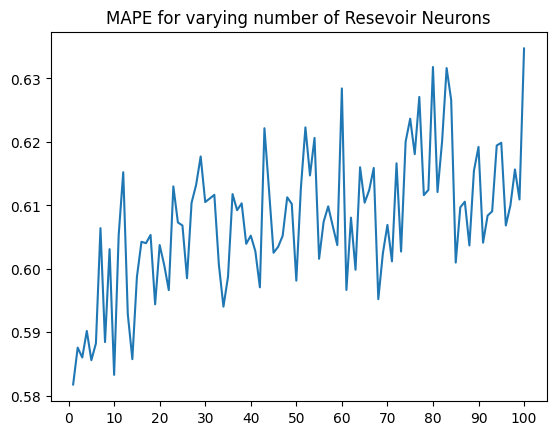

In [117]:
plt.plot(neurons, ms)
plt.title("MAPE for varying number of Resevoir Neurons")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

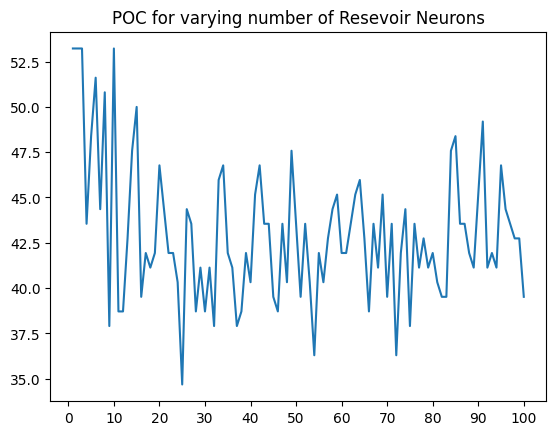

In [118]:
plt.plot(neurons, ps)
plt.title("POC for varying number of Resevoir Neurons")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [122]:
def runESN_eval2(train, test, sr):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    #X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    #X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 10,
          sparsity=0.2,
          random_state=23,
          spectral_radius=sr,
          noise = 0.005)
    
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

In [136]:
rs = []
ms = []
ps = []
ts = []
srs = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3]

for i in srs:
    y_pred, y_test, r, m, p, t = runESN_eval2(KO_train10, KO_test6, i)
    rs.append(r)
    ms.append(m)
    ps.append(p)
    ts.append(t)

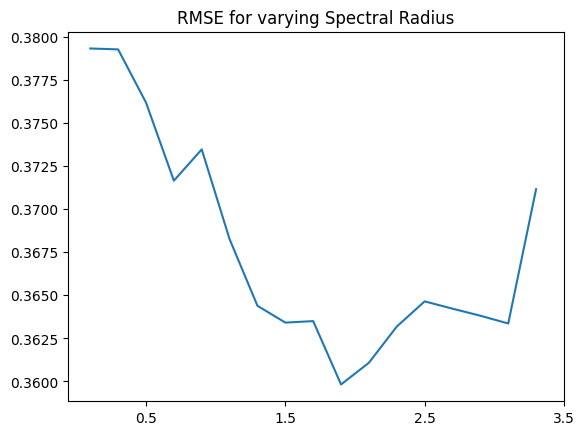

In [147]:
plt.plot(srs, rs)
plt.title("RMSE for varying Spectral Radius")
plt.xticks([0.5, 1.5, 2.5, 3.5])
plt.show()

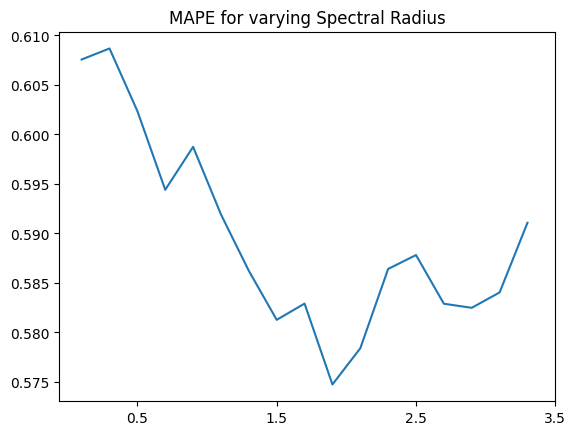

In [146]:
plt.plot(srs, ms)
plt.title("MAPE for varying Spectral Radius")
plt.xticks([0.5, 1.5, 2.5, 3.5])
plt.show()

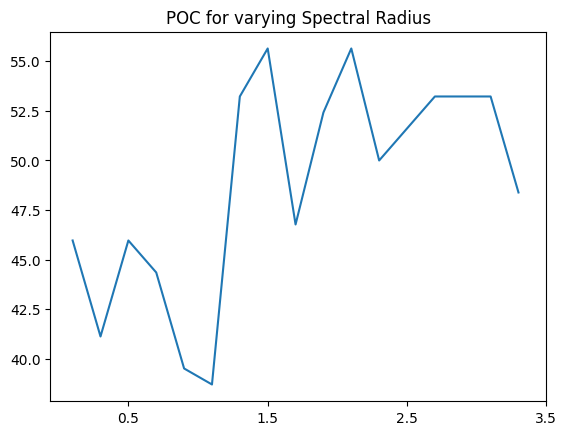

In [148]:
plt.plot(srs, ps)
plt.title("POC for varying Spectral Radius")
plt.xticks([0.5, 1.5, 2.5, 3.5])
plt.show()

In [21]:
def runESN(train, test):
    xsc = MinMaxScaler()
    ysc = MinMaxScaler()

    X_train, y_train = split_label(train)
    X_test, y_test = split_label(test)

    X_train_scaled = xsc.fit_transform(X_train)
    X_train_scaled = np.array(X_train_scaled)
    #X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

    X_test_scaled = xsc.transform(X_test)
    X_test_scaled = np.array(X_test_scaled)
    #X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = ysc.fit_transform(y_train).reshape(1, -1)[0]
    y_test_scaled = ysc.transform(y_test).reshape(1, -1)[0]

    model = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 10,
          sparsity=0.2,
          random_state=23,
          spectral_radius=2.1,
          noise = 0.005)
    
    strt = time.time()
    history = model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    end = time.time()
    
    y_pred_1 = ysc.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(1,-1)[0]
    y_test_1 = ysc.inverse_transform(np.array(y_test_scaled).reshape(-1,1)).reshape(1,-1)[0]

    return y_pred_1, y_test_1, rmse(y_test_1, y_pred_1), mape(y_test_1, y_pred_1), poc(X_test, y_test_1, y_pred_1), (end - strt)

### KO Stock

10Y Data - 6Mo Prediction
RMSE: 0.361087201313346
MAPE: 0.5784026955511554
POC: 55.64516129032258
Execution Time: 0.03953957557678223 seconds 



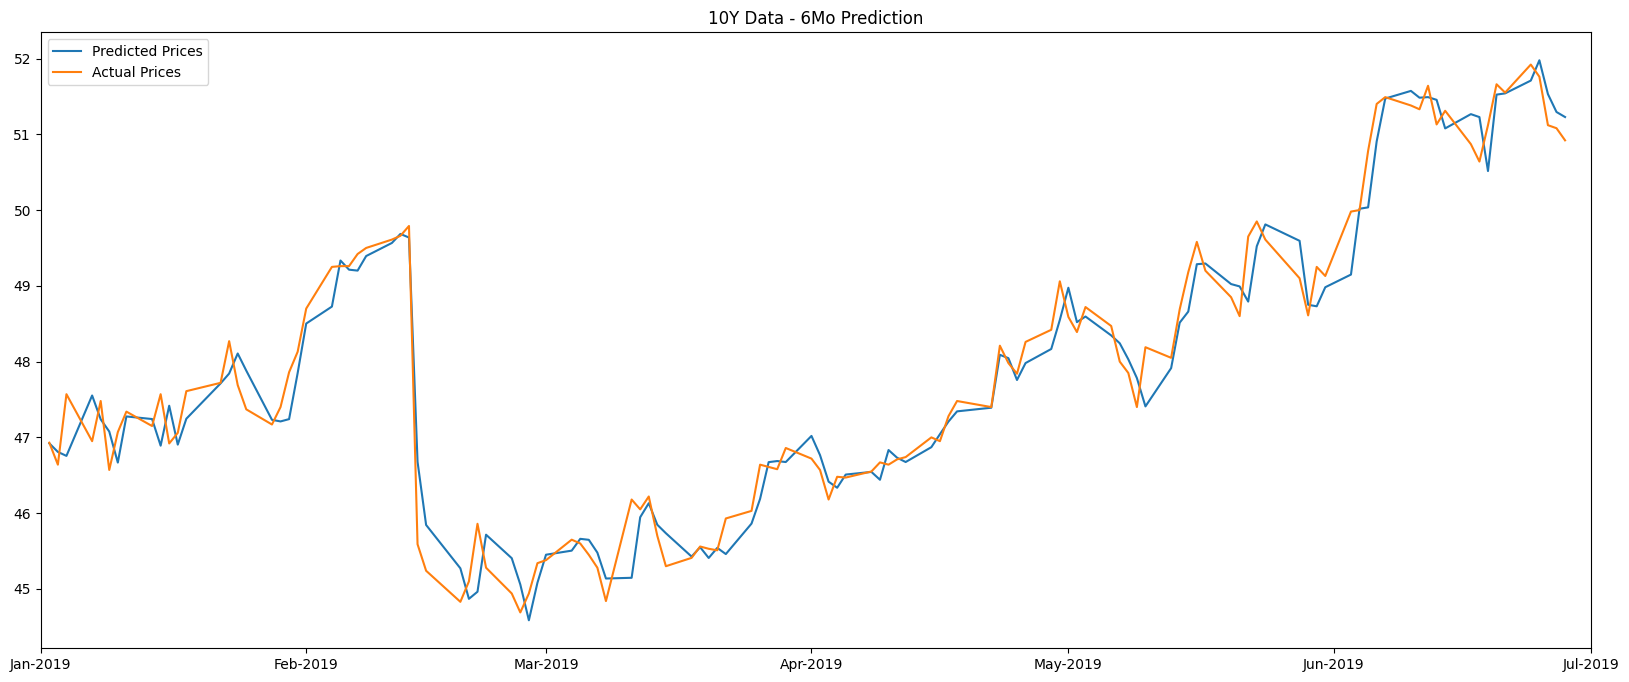

In [143]:
y_pred, y_test, r, m, p, t = runESN(KO_train10, KO_test6)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")

10Y Data - 1Mo Prediction
RMSE: 0.410020824953769
MAPE: 0.7144831798834641
POC: 57.14285714285714
Execution Time: 0.0379941463470459 seconds 

5Y Data - 1Mo Prediction
RMSE: 0.4144151161398936
MAPE: 0.7223631390387071
POC: 42.857142857142854
Execution Time: 0.021907329559326172 seconds 

5Y Data - 6Mo Prediction
RMSE: 0.3734750050188314
MAPE: 0.5948298578227443
POC: 45.96774193548387
Execution Time: 0.019927024841308594 seconds 



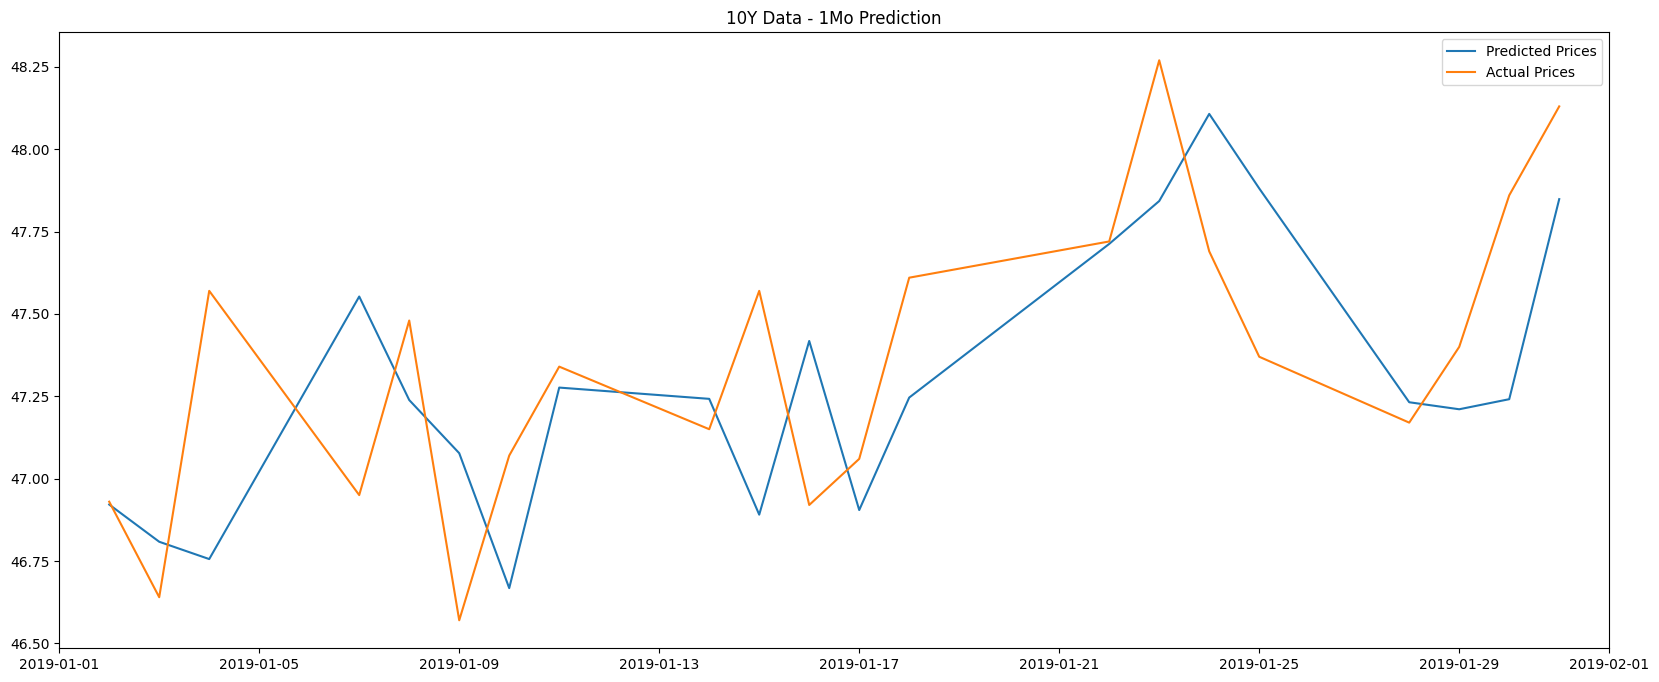

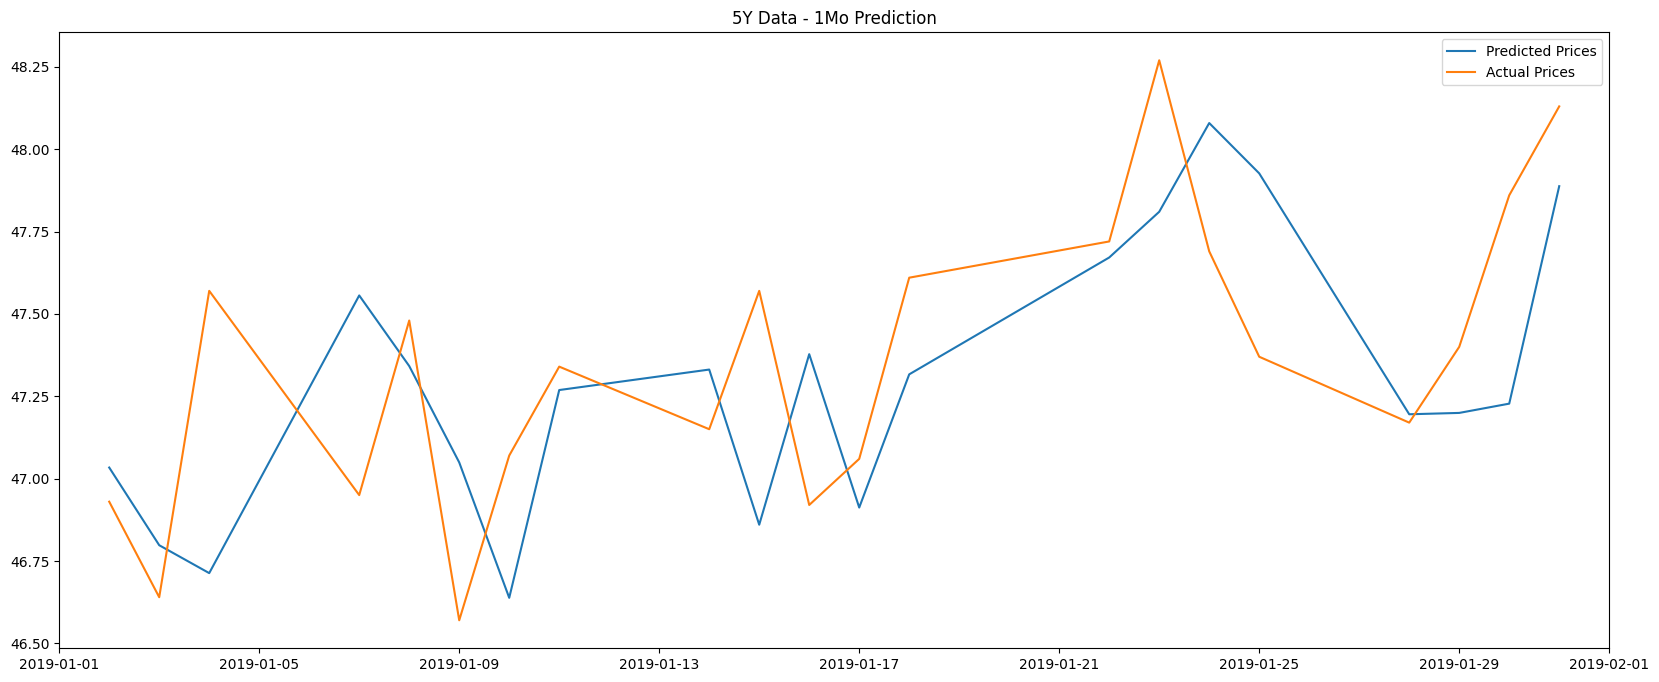

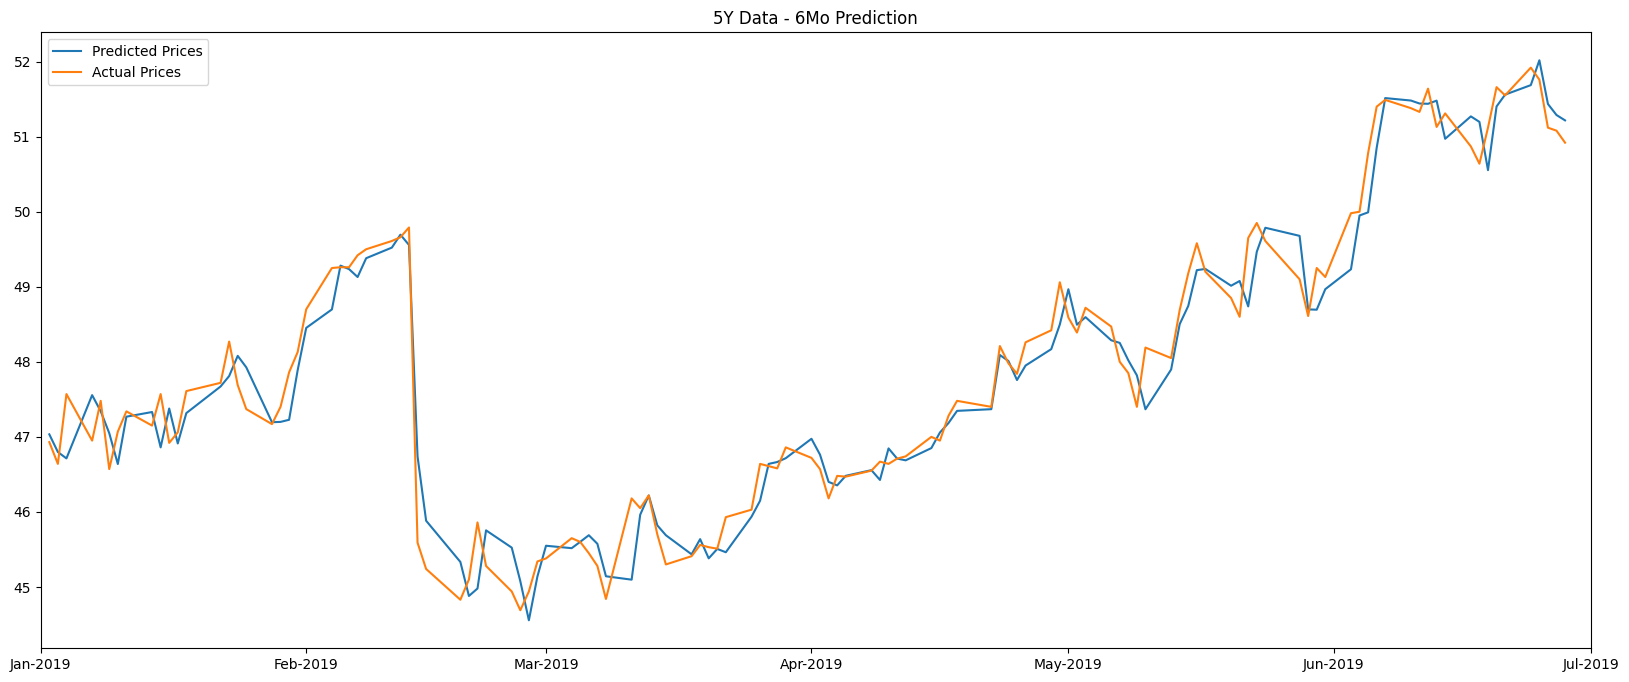

In [149]:
y_pred, y_test, r, m, p, t = runESN(KO_train10, KO_test1)
print("10Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "10Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runESN(KO_train5, KO_test1)
print("5Y Data - 1Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 1, "5Y Data - 1Mo Prediction")

y_pred, y_test, r, m, p, t = runESN(KO_train5, KO_test6)
print("5Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "5Y Data - 6Mo Prediction")

### AMD Stock

10Y Data - 6Mo Prediction
RMSE: 0.7331508805119126
MAPE: 2.2084400143721665
POC: 62.096774193548384
Execution Time: 0.06254196166992188 seconds 



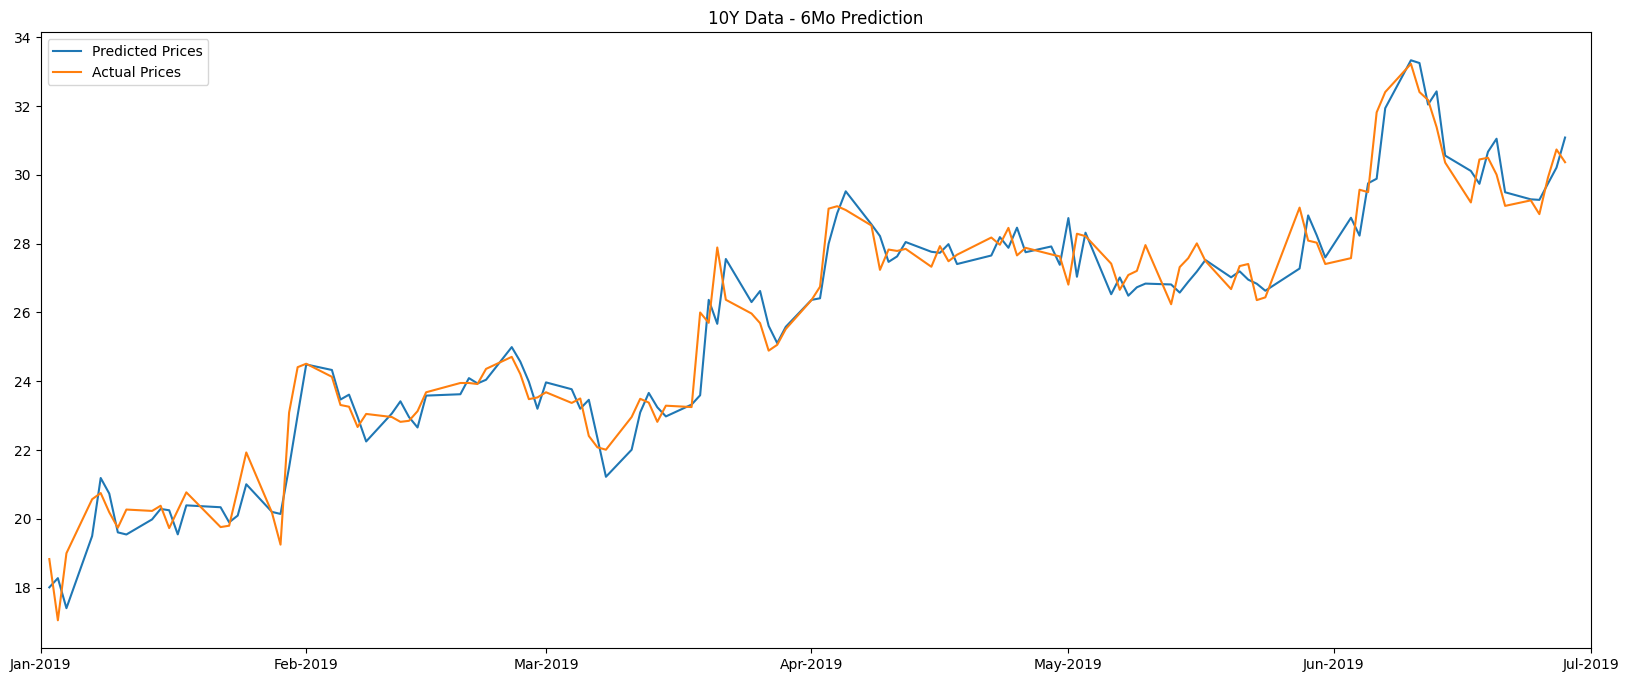

In [22]:
y_pred, y_test, r, m, p, t = runESN(AMD_train10, AMD_test6)
print("10Y Data - 6Mo Prediction")
print("RMSE:", r)
print("MAPE:", m)
print("POC:", p)
print("Execution Time:", t, "seconds \n")
plot_pred(y_test, y_pred, 6, "10Y Data - 6Mo Prediction")